In [1]:
import numpy as np
import pandas as pd
import os
import re
from IPython.display import display
import matplotlib.pyplot as plt
from curve_functions import FunctionProvider
import sklearn.preprocessing as prep
import typing

RESULTS_BACKUP_PATH = '/home/mnapravnik/Documents/PhD/Efficiency-of-dragging-gestures/Results_backup'

In [2]:
%%time
# first, gather all of the data related to drawn figures
def get_drawn_figures(test:int=0):
    
    path = f'{RESULTS_BACKUP_PATH}{test}'
    columns = [
        'Username',
        'TestIndex',
        'Device',
        'FigureID',
        'Projection',
        'ProjectionName',
        'Order',
        'Fullpath',
        'Npoints'
    ]
    df = pd.DataFrame(columns=columns)
    
    for user_direntry in os.scandir(path):
        # each directory is named after the user participant
        _username = user_direntry.name
#         _username = re.sub(' ', '_', _username)
        
        for device_direntry in os.scandir(user_direntry.path):
            _device = device_direntry.name
#             _device = re.sub(' ', '_', _device)
                
            for drawing_direntry in os.scandir(device_direntry.path):
                _only_numbers_and_underscore = re.sub('[^0-9,_]', '', drawing_direntry.name)
                _figureid, _projection, _order = _only_numbers_and_underscore.split('_')
                _figureid = int(_figureid)
                _projection = int(_projection)
                _order = int(_order)
                
                # check how many drawn points there are
                npoints = 0
                with open(drawing_direntry.path) as file:
                    npoints = len(file.readlines())
                
                # there seems to be a bug with polar projections
                # where figures in projection 2 are named as projection 3
                # and that happens only when
                # figureid is 0, so just fix it here, on-the-go
                if (_figureid == 0):
                    if(_projection == 2):
                        _projection = 3
                    elif(_projection == 3):
                        _projection = 2
                _projection_name = 'Cartesian' if _projection in [0, 1] else 'Polar'
                    
                
                # append the row to the end of the dataframe
                df.loc[len(df)] = [
                    _username,
                    test,
                    _device,
                    _figureid,
                    _projection,
                    _projection_name,
                    _order,
                    drawing_direntry.path,
                    npoints
                ]
#     df.set_index(['Username'], inplace=True)
    return df

def get_timelogs():
    df = pd.read_csv('timelogs.csv')
#     display(df)
    return df

def merge_drawings_with_len_and_kappa(df):
    len_df = pd.read_json('index_of_difficulty-length.json')
    kappa_df = pd.read_json('index_of_difficulty-kappa.json')
    # in these two jsons, the column names are projections
    # i.e. [0, 1, 2, 3]
    # and indices are figure IDs
    
    df['Length'] = -1.0
    df['Kappa'] = -1.0
    
    for figureid in len_df.index:
        for projection_id in len_df.columns:
            df_tmp_ids = df.query(
                f'FigureID == {figureid} and ' +
                f'Projection == {projection_id}'
            ).index
            
            df.loc[df_tmp_ids, 'Kappa'] = kappa_df.loc[figureid, projection_id]
            df.loc[df_tmp_ids, 'Length'] = len_df.loc[figureid, projection_id]     
    
    return df

def merge_timelogs_with_drawings(timelogs_df, drawings_df):
    drawings_df['Drawing time'] = 0.0
    drawings_df['Timestamp'] = 0

    # sort drawings by the order they appeared in
    drawings_df.sort_values('Order', inplace=True)
    timelogs_df.sort_values('Logging timestamp', inplace=True)
    
    for _idx in timelogs_df.index:
        timelog_entry = timelogs_df.loc[_idx]
        username = timelog_entry['Participant name']
        device = timelog_entry['Device']
        figureid = timelog_entry['Function ID']
        projection_name = timelog_entry['Function projection']
        test_index = timelog_entry['Test mode']
        # there were two drawings for each function
        # so 'drawing' will have two entries
        # sorted in chronological order
        drawing = drawings_df.query(
            f'Device == "{device}" and '
            f'FigureID == {figureid} and '
            f'Username == "{username}" and '
            f'ProjectionName == "{projection_name}" and '
            f'TestIndex == {test_index}'
        )
        
        _drwg_id = drawing.index[0]
        
        # if this row has already been filled
        # i.e. if this drawing was already paired with a timestamp
        # then the other (the second) drawing has to be paired now
        if drawing.loc[_drwg_id, 'Timestamp'] > 0:
            _drwg_id = drawing.index[1]
        
        drawings_df.loc[_drwg_id, 'Timestamp'] = timelog_entry['Logging timestamp']
        drawings_df.loc[_drwg_id, 'Drawing time'] = timelog_entry['Drawing time']
    drawings_df.sort_values(['Timestamp', 'Username'], inplace=True)
    return drawings_df
    
df = get_drawn_figures(0)
df = pd.concat([df, get_drawn_figures(1)], ignore_index=True)

timelogs = get_timelogs()
df = merge_timelogs_with_drawings(timelogs, df)

df = merge_drawings_with_len_and_kappa(df)
# there is a mistake here -> the entry under loc 1703 contains a
# very small drawing time (0.03sec fo 100'+ Npoints)
# so just fix that here
df.at[1703, 'Drawing time'] *= 1000

display(df)
display(df.Username.unique())

,Username,TestIndex,Device,FigureID,Projection,ProjectionName,Order,Fullpath,Npoints,Drawing time,Timestamp,Length,Kappa
666,rpolic,0,Mouse,0,0,Cartesian,0,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,494,18.611872,1608756223,10.765825,0.000000
664,rpolic,0,Mouse,3,0,Cartesian,1,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,1206,44.369353,1608756274,18.647263,13.064420
659,rpolic,0,Mouse,2,0,Cartesian,2,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,1085,38.333776,1608756326,17.033850,8.823529
662,rpolic,0,Mouse,3,0,Cartesian,3,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,1313,51.449784,1608756388,18.647263,13.064420
655,rpolic,0,Mouse,1,2,Polar,4,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,1502,44.239386,1608756455,18.421721,3.317192
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,bado97,1,Graphic tablet,1,1,Cartesian,19,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,245,11.930139,1613305774,10.765825,0.000000
1990,bado97,1,Graphic tablet,3,1,Cartesian,20,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,556,26.365682,1613305809,14.173052,12.004836
1985,bado97,1,Graphic tablet,2,3,Polar,21,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,853,31.388956,1613305858,16.193773,10.927319
1981,bado97,1,Graphic tablet,4,1,Cartesian,22,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,823,37.710711,1613305906,22.151328,21.866640


array(['rpolic', 'Marin_Vidakovic_Lipovac', 'Mateja Napravnik', 'mrGauss',
       'Shanko', 'mtvrdinic', 'asubasic', 'azahtila', 'dmakar',
       'mduvnjak', 'ssimunic', 'Vrtni_Patuljak', 'wdragon', 'aronta',
       'dgrdinic', 'kknezic', 'lotovic', 'SadilaJeMare', 'Zmaj Zemun',
       'kfilipcic', 'kskunca', 'mdudic', 'mnjiric', 'bado97'],
      dtype=object)

CPU times: user 10.1 s, sys: 466 ms, total: 10.5 s
Wall time: 13.8 s


Entry ID: 2164


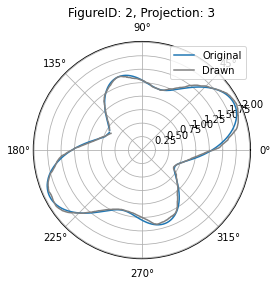

In [3]:
def get_drawn_coordinates(df_entry, scale:bool=False):
    _drawingx, _drawingy = [], []
    with open(df_entry.Fullpath) as file:
        for line in file:
            pointx, pointy = line.split()
            pointx = float(pointx)
            pointy = float(pointy)
            _drawingx.append(pointx)
            _drawingy.append(pointy)
    return _drawingx, _drawingy

def scale_coordinates(df_entry, x, y):
    from display_properties import CARTESIAN_PLOT_LIMITS, POLAR_PLOT_LIMITS
    x = np.array(x)
    y = np.array(y)
    if df_entry.Projection in [0,1]:
        # Cartesian plot
        y = (y - CARTESIAN_PLOT_LIMITS['y'][0]) / CARTESIAN_PLOT_LIMITS['y'][1]
        x = (x - CARTESIAN_PLOT_LIMITS['x'][0]) / CARTESIAN_PLOT_LIMITS['x'][1]
    else:
        # Polar plot
        # due to scaling, polar plots will look a bit idiotic
        y = (y - POLAR_PLOT_LIMITS['y'][0]) / POLAR_PLOT_LIMITS['y'][1]
        x = (x - POLAR_PLOT_LIMITS['x'][0]) / POLAR_PLOT_LIMITS['x'][1]
    return x, y


def unscale_coordinates(x, y, projection):
    from display_properties import CARTESIAN_PLOT_LIMITS, POLAR_PLOT_LIMITS
    x = np.array(x)
    y = np.array(y)
    if projection in [0,1]:
        # Cartesian plot
        y = y * CARTESIAN_PLOT_LIMITS['y'][1] + CARTESIAN_PLOT_LIMITS['y'][0]
        x = y * CARTESIAN_PLOT_LIMITS['x'][1] + CARTESIAN_PLOT_LIMITS['x'][0]
    else:
        # Polar plot
        y = y * POLAR_PLOT_LIMITS['y'][1] + POLAR_PLOT_LIMITS['y'][0]
        x = y * POLAR_PLOT_LIMITS['x'][1] + POLAR_PLOT_LIMITS['x'][0]
    return x, y 
    

def get_real_coordinates(df_entry, x):
    fp = FunctionProvider()
    difficulty = int(df_entry.FigureID / 2)
    task = int(df_entry.FigureID % 2)
    func_y = fp.provide_function_y(difficulty, task, x, df_entry.Projection)
    return x, func_y


# Inspect drawn vs. original data
def plot_function_and_drawing(df_entry):
    _drawingx, _drawingy = get_drawn_coordinates(df_entry)
    
    _, func_y = get_real_coordinates(df_entry, _drawingx)
#     _drawingx, _drawingy = scale_coordinates(df_entry, _drawingx, _drawingy)
#     _, func_y = scale_coordinates(df_entry, _drawingx, func_y)
    
    if df_entry.ProjectionName == 'Cartesian':
        # cartesian projection
        fig, ax = plt.subplots()
    else:
        # polar projection
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax = fig.gca()
    ax.plot(_drawingx, func_y, label='Original')
    ax.plot(_drawingx, _drawingy, label='Drawn', color='gray')
    ax.set_title(
        f'FigureID: {df_entry.FigureID}, Projection: {df_entry.Projection}'
    )
    ax.legend()
    plt.show()

entry = df.query('Projection == 3 and FigureID == 2').iloc[8]
print('Entry ID:', entry.name)
plot_function_and_drawing(entry)

In [72]:
# prepare data for training

def prepare_points(df, columncnt:int, interpolate:bool=True):
    """
    This accepts the original dataframe as input
    and returns the points encoded and ready for training.
    All coordinates are scaled between [0, 1]
    and scaled to be the same length (columncnt is the length).
    
    If interpolate is True, then then the drawn function will be interpolated
    to contain exactly `columncnt` values. If interpolate is False,
    then drawn functions will be zero-padded to contain `columnct` values.
    For example, if a user has drawn 300 points and columncnt is 500,
    if interpolate is true, then there will be additional 200 points interpolated
    between the drawn 300 points. If interpolate is False,
    then only additional 200 points will be appended to the original 300 points
    and that would be it.
    
    Returns three values:
    - the value on the X axis
    - the value drawn by the user
    - the real value of the function
    
    """
    def convert_to_same_size(columncnt:int, x, y):
        resultx = np.zeros(columncnt)
        resulty = np.zeros(columncnt)
        if(len(x) < columncnt):
            # this has the effect of zero-padding
            # because were adding the drawings to an array of zeros
            resultx[:len(x)] = x
            resulty[:len(y)] = y
        else:
            # otherwise crop the drawing
            resultx = x[:columncnt]
            resulty = y[:columncnt]
        return resultx, resulty
    
    x = []
    drawn_y = []
    real_y = []
    for index in df.index:
        entry = df.loc[index]
        # first, get the drawn coordinates
        _drawingx, _drawingy = get_drawn_coordinates(entry)
        tmp1, tmp2 = _drawingx.copy(), _drawingy.copy()
        
        # now, get the real function coordinates
        # if the function is being interpolated then all function have the same X
        # if it is not being interpolated then we use the original-drawn X
        func_x = X_FOR_ALL_FUNC if interpolate is True else _drawingx
        # get the Y values based on X
        _, func_y = get_real_coordinates(entry, func_x)
        
        if interpolate is True:
            # interpolate the drawn curves so they always have the same x values
            if entry.ProjectionName == 'Cartesian':
                _drawingy = np.interp(func_x, _drawingx, _drawingy)
            else:
                # polar function have a period of 2pi so interpolate them as such
                _drawingy = np.interp(func_x, _drawingx, _drawingy, period=360)
            _drawingx = func_x
        
#             # test to see if the interpolated function still looks like the original
#             if entry.ProjectionName == 'Cartesian':
#                 # cartesian projection
#                 fig, ax = plt.subplots()
#             else:
#                 # polar projection
#                 fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
#             ax.plot(func_x, func_y, label='original func')
#             ax.plot(tmp1, tmp2, label='original drawn')
#             ax.plot(_drawingx, _drawingy, label='interp')
#             ax.legend()
#             plt.show()
        elif interpolate is False:
            # add zero padding where necessary
            _, func_y = convert_to_same_size(columncnt, x=_drawingx, y=func_y)
            _drawingx, _drawingy = convert_to_same_size(columncnt, x=_drawingx, y=_drawingy)
        
        # scale coords between 0 and 1
        _, func_y = scale_coordinates(entry, _drawingx, func_y)
        _drawingx, _drawingy = scale_coordinates(entry, _drawingx, _drawingy)
        
        x.append(_drawingx)
        drawn_y.append(_drawingy)
        real_y.append(func_y)
        
    x = np.array(x)
    drawn_y = np.array(drawn_y)
    real_y = np.array(real_y)
    
    return x, drawn_y, real_y

def prepare_dataset_for_user_classification(df, columncnt:int, interpolate:bool=False):
    x, drawn_y, real_y = prepare_points(df, columncnt, interpolate=interpolate)
    y = np.abs(drawn_y - real_y)
    
    # now prepare the rest: i.e. the device used, the projection and the usernames
    proj_encoder = prep.LabelBinarizer()
    proj_encoded = proj_encoder.fit_transform(df.ProjectionName)
    user_encoder = prep.LabelBinarizer()
    user_encoded = user_encoder.fit_transform(df.Username)
    # the devices only have two values: Mouse & Graphic tablet
    # so use Label Encoder instead
    device_encoder = prep.LabelBinarizer()
    device_encoded = device_encoder.fit_transform(df.Device)
    
    device_encoded = np.array(device_encoded, dtype='int16')
    user_encoded = np.array(user_encoded, dtype='int16')
    proj_encoded = np.array(proj_encoded, dtype='int16')
    
    from collections import namedtuple
    Entry = namedtuple('Entry', ['encoded', 'encoder', 'name'])
    entries_to_add_to_df: typing.List[Entry] = [
        Entry(proj_encoded, proj_encoder, 'Projection'),
        Entry(user_encoded, user_encoder, 'Username'),
        Entry(device_encoded, device_encoder, 'Device'),
        Entry(x, None, 'Xcoord'),
        Entry(drawn_y, None, 'drawnY'),
        Entry(np.expand_dims(df['Drawing time'], 1), None, 'Drawing time')
#         Entry(real_y, None, 'realY'),
#         Entry(y, None, 'YDiff')
    ]
    
    # now, join everything into a single dataframe
    # first, get column names to use
    columns = []
    for encoded, encoder, name in entries_to_add_to_df:
        col_names = []
        for _idx in range(np.shape(encoded)[1]):
            _tmp = _idx
            if(encoder is not None):
                _tmp = encoder.classes_[_idx]
            col_names.append(f'{name}_{_tmp}')
        
        columns = columns + col_names
    # horizontally stack all of the encoded values
    data = np.hstack([entry.encoded for entry in entries_to_add_to_df])
    df = pd.DataFrame(
        columns=columns,
        data=data,
        index=df.index
    )
    return df

df_to_use = df.copy()
# df_to_use = df.copy()
display(df_to_use)
columncnt = 1024
from display_properties import X_RANGE
# this is the X RANGE for ALLLLL (!!!) OF THE functions
# both the drawn and the generated (original) functions
X_FOR_ALL_FUNC = np.linspace(X_RANGE['start'], X_RANGE['end'], columncnt)

encoded_df = prepare_dataset_for_user_classification(
    df_to_use,
    columncnt=columncnt,
    interpolate=True
)
display(encoded_df)

,Username,TestIndex,Device,FigureID,Projection,ProjectionName,Order,Fullpath,Npoints,Drawing time,Timestamp,Length,Kappa
666,rpolic,0,Mouse,0,0,Cartesian,0,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,494,18.611872,1608756223,10.765825,0.000000
664,rpolic,0,Mouse,3,0,Cartesian,1,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,1206,44.369353,1608756274,18.647263,13.064420
659,rpolic,0,Mouse,2,0,Cartesian,2,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,1085,38.333776,1608756326,17.033850,8.823529
662,rpolic,0,Mouse,3,0,Cartesian,3,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,1313,51.449784,1608756388,18.647263,13.064420
655,rpolic,0,Mouse,1,2,Polar,4,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,1502,44.239386,1608756455,18.421721,3.317192
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,bado97,1,Graphic tablet,1,1,Cartesian,19,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,245,11.930139,1613305774,10.765825,0.000000
1990,bado97,1,Graphic tablet,3,1,Cartesian,20,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,556,26.365682,1613305809,14.173052,12.004836
1985,bado97,1,Graphic tablet,2,3,Polar,21,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,853,31.388956,1613305858,16.193773,10.927319
1981,bado97,1,Graphic tablet,4,1,Cartesian,22,/home/mnapravnik/Documents/PhD/Efficiency-of-d...,823,37.710711,1613305906,22.151328,21.866640


,Projection_Cartesian,Username_Marin_Vidakovic_Lipovac,Username_Mateja Napravnik,Username_SadilaJeMare,Username_Shanko,Username_Vrtni_Patuljak,Username_Zmaj Zemun,Username_aronta,Username_asubasic,Username_azahtila,...,drawnY_1015,drawnY_1016,drawnY_1017,drawnY_1018,drawnY_1019,drawnY_1020,drawnY_1021,drawnY_1022,drawnY_1023,Drawing time_0
666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.727969,0.729165,0.729165,0.729813,0.730360,0.730360,0.730905,0.731556,0.731556,18.611872
664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.645490,0.645490,0.645490,0.645490,0.645490,0.645490,0.645490,0.645490,0.645490,44.369353
659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.672131,0.670186,0.667452,0.664313,0.660382,0.658640,0.656248,0.655053,0.651467,38.333776
662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.646686,0.647881,0.648131,0.648711,0.649076,0.649076,0.649076,0.649076,0.649076,51.449784
655,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.884402,0.887134,0.887641,0.887457,0.888674,0.889040,0.890808,0.679388,0.892593,44.239386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.360370,0.360177,0.359983,0.359801,0.359801,0.359801,0.359801,0.359801,0.359801,11.930139
1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.817866,0.816222,0.814668,0.813361,0.812055,0.809255,0.807513,0.805771,0.803277,26.365682
1985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.471847,0.476277,0.480562,0.485337,0.489090,0.495664,0.500728,0.506754,0.509263,31.388956
1981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.583344,0.572855,0.565016,0.556097,0.546807,0.539109,0.531596,0.518105,0.516392,37.710711


In [63]:
train_df = encoded_df[df_to_use.TestIndex == 0].query('Projection_Cartesian > 0.5')
test_df = encoded_df[df_to_use.TestIndex == 1].query('Projection_Cartesian > 0.5')

train_dfY = train_df.filter(regex='Username_*')
train_dfX = train_df.drop(train_dfY.columns, axis=1)

test_dfY = test_df.filter(regex='Username_*')
test_dfX = test_df.drop(test_dfY.columns, axis=1)

display(train_dfX)
display(train_dfY)

,Projection_Cartesian,Device_Graphic tablet,Xcoord_0,Xcoord_1,Xcoord_2,Xcoord_3,Xcoord_4,Xcoord_5,Xcoord_6,Xcoord_7,...,drawnY_4991,drawnY_4992,drawnY_4993,drawnY_4994,drawnY_4995,drawnY_4996,drawnY_4997,drawnY_4998,drawnY_4999,Drawing time_0
655,1.0,1.0,0.0,0.0002,0.0004,0.0006,0.0008,0.001,0.0012,0.0014,...,0.890786,0.890776,0.815463,0.693246,0.642601,0.642598,0.756595,0.892594,0.892593,44.239386
656,1.0,1.0,0.0,0.0002,0.0004,0.0006,0.0008,0.001,0.0012,0.0014,...,0.559288,0.559282,0.559276,0.559271,0.559267,0.559264,0.559262,0.559262,0.559262,45.712627
669,1.0,1.0,0.0,0.0002,0.0004,0.0006,0.0008,0.001,0.0012,0.0014,...,0.390768,0.394031,0.388790,0.383548,0.378306,0.387042,0.387042,0.387043,0.387043,70.778275
663,1.0,1.0,0.0,0.0002,0.0004,0.0006,0.0008,0.001,0.0012,0.0014,...,0.841558,0.659312,0.890767,0.890758,0.756747,0.814372,0.756745,0.890743,0.890743,41.985768
651,1.0,1.0,0.0,0.0002,0.0004,0.0006,0.0008,0.001,0.0012,0.0014,...,0.507438,0.507438,0.507438,0.507438,0.507438,0.507438,0.507438,0.507438,0.507438,33.086758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,1.0,1.0,0.0,0.0002,0.0004,0.0006,0.0008,0.001,0.0012,0.0014,...,0.409090,0.424025,0.501019,0.523626,0.418561,0.501273,0.548151,0.548151,0.548151,65.432089
858,1.0,1.0,0.0,0.0002,0.0004,0.0006,0.0008,0.001,0.0012,0.0014,...,0.721420,0.721858,0.722243,0.722237,0.722232,0.722232,0.722232,0.722232,0.722232,32.022578
846,1.0,1.0,0.0,0.0002,0.0004,0.0006,0.0008,0.001,0.0012,0.0014,...,0.710008,0.710297,0.710585,0.710874,0.711121,0.711121,0.711121,0.711121,0.711121,33.816086
829,1.0,0.0,0.0,0.0002,0.0004,0.0006,0.0008,0.001,0.0012,0.0014,...,0.725389,0.725681,0.725947,0.725947,0.725947,0.725947,0.725947,0.725947,0.725947,35.322237


,Username_Marin_Vidakovic_Lipovac,Username_Mateja Napravnik,Username_SadilaJeMare,Username_Shanko,Username_Vrtni_Patuljak,Username_Zmaj Zemun,Username_aronta,Username_asubasic,Username_azahtila,Username_bado97,...,Username_kskunca,Username_lotovic,Username_mdudic,Username_mduvnjak,Username_mnjiric,Username_mrGauss,Username_mtvrdinic,Username_rpolic,Username_ssimunic,Username_wdragon
655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Classification model in PyTorch
https://stackabuse.com/introduction-to-pytorch-for-classification/

In [64]:
import torch
import torch.nn as nn
# limit CPU usage
torch.set_num_threads(50)

In [65]:
class ClassificationModel(nn.Module):
    def __init__(self, hidden_layer_sizes:typing.List[int], input_size:int, output_size=int, dropout=0.3):
        super().__init__()
        _all_layers = []
        for _size in hidden_layer_sizes:
            _all_layers.append(nn.Linear(input_size, _size))
            _all_layers.append(nn.ReLU(inplace=True))
            _all_layers.append(nn.BatchNorm1d(_size))
            # apply dropout if specified so
            if dropout > 0:
                _all_layers.append(nn.Dropout(dropout))
            # update the input size of the following layer
            input_size = _size
        # this is the output layer
        _all_layers.append(nn.Linear(in_features=hidden_layer_sizes[-1], out_features=output_size))
        # apply another activation function to the output layer, so that the output is scaled
#         _all_layers.append(nn.Softmax(dim=1))
        
        # finally, create a model that has all these layers
        # aligned in a sequence
        # this means the layers will be called/processed one after the other
        self.layers = nn.Sequential(*_all_layers)
    
    def forward(self, x):
#         print(x[0:10])
        return self.layers(x)

# convert the pandas df into torch tensor
torch_train_dfX = torch.tensor(np.array(train_dfX, dtype='float32'))
torch_train_dfY = torch.tensor(np.array(train_dfY, dtype='float32'))
torch_test_dfX = torch.tensor(np.array(test_dfX, dtype='float32'))
torch_test_dfY = torch.tensor(np.array(test_dfY, dtype='float32'))

In [66]:
input_size = torch_train_dfX.shape[1]
output_size = torch_train_dfY.shape[1]
display(input_size, output_size)
model = ClassificationModel([2**10, 2**8, 2**6], input_size=input_size, output_size=output_size, dropout=0.)
display(model)

10003

24

ClassificationModel(
  (layers): Sequential(
    (0): Linear(in_features=10003, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1024, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=64, out_features=24, bias=True)
  )
)

In [67]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001)
epochs = 10
aggregated_losses = []

for _epoch_idx in range(epochs):
    model.train()
    y_pred = model(torch_train_dfX)
    loss_in_this_epoch = loss_function(y_pred, torch_train_dfY)
    aggregated_losses.append(loss_in_this_epoch)
    
    with torch.no_grad():
        model.eval()
        y_val = model(torch_test_dfX)
        test_loss = loss_function(y_val, torch_test_dfY)
    _end = '\r'
    if (_epoch_idx + 1) % 10 == 0:
        _end = '\n'
    print(f'Epoch {_epoch_idx+1:4} ===> loss {loss_in_this_epoch.item():10.8f}, test_loss {test_loss}', end=_end)

    optimizer.zero_grad()
    # propagate the calculated loss backward through the network
    loss_in_this_epoch.backward()
    # update the weights in the network
    optimizer.step()

Epoch    1 ===> loss 3.28127766, test_loss 3.1796107292175293
Epoch    2 ===> loss 3.09637904, test_loss 3.179989814758301
Epoch    3 ===> loss 3.04546189, test_loss 3.18054461479187
Epoch    4 ===> loss 2.98800468, test_loss 3.181006908416748
Epoch    5 ===> loss 2.95902681, test_loss 3.181380271911621
Epoch    6 ===> loss 2.93448853, test_loss 3.181853771209717
Epoch    7 ===> loss 2.90662503, test_loss 3.1822690963745117
Epoch    8 ===> loss 2.88499022, test_loss 3.1825554370880127
Epoch    9 ===> loss 2.86563969, test_loss 3.182821035385132
Epoch   10 ===> loss 2.84583950, test_loss 3.1830813884735107


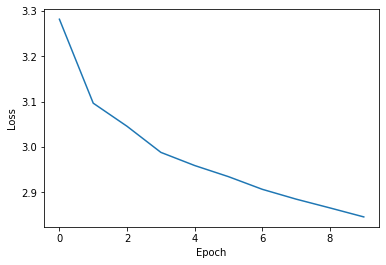

Loss on test data: 3.1830403804779053
tensor([16, 16, 16, 16, 16, 16, 16, 16, 16, 16])
tensor([21, 21, 21, 21, 21, 21, 21, 21, 21, 21])
tensor([[-0.1266, -0.1079, -0.1814,  0.1210, -0.0355, -0.2512,  0.0156,  0.0941,
          0.0933, -0.0949,  0.0935, -0.1667, -0.0439, -0.1759,  0.0640,  0.0425,
          0.2714, -0.1758,  0.0049, -0.1170, -0.0288,  0.1085,  0.1963,  0.1436],
        [-0.1221, -0.0669, -0.1854,  0.1567, -0.0264, -0.1940,  0.0087,  0.0866,
          0.0715, -0.1278,  0.0862, -0.1525, -0.0578, -0.1657,  0.0278,  0.0557,
          0.2652, -0.1753, -0.0304, -0.0980, -0.0114,  0.0944,  0.2001,  0.1308],
        [-0.1172, -0.0794, -0.1875,  0.1436, -0.0278, -0.2110,  0.0121,  0.0926,
          0.0786, -0.1186,  0.0898, -0.1602, -0.0510, -0.1646,  0.0393,  0.0536,
          0.2682, -0.1712, -0.0195, -0.1010, -0.0156,  0.1025,  0.1983,  0.1331],
        [-0.1241, -0.0671, -0.1907,  0.1564, -0.0267, -0.1899,  0.0064,  0.0900,
          0.0665, -0.1272,  0.0892, -0.1511, -0.058

,Username_Marin_Vidakovic_Lipovac,Username_Mateja Napravnik,Username_SadilaJeMare,Username_Shanko,Username_Vrtni_Patuljak,Username_Zmaj Zemun,Username_aronta,Username_asubasic,Username_azahtila,Username_bado97,...,Username_kskunca,Username_lotovic,Username_mdudic,Username_mduvnjak,Username_mnjiric,Username_mrGauss,Username_mtvrdinic,Username_rpolic,Username_ssimunic,Username_wdragon
1820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        24
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00        24
           8       0.00      0.00      0.00        24
           9       0.00      0.00      0.00        24
          10       0.00      0.00      0.00        24
          11       0.00      0.00      0.00        24
          12       0.00      0.00      0.00        24
          13       0.00      0.00      0.00        24
          14       0.00      0.00      0.00        24
          15       0.00      0.00      0.00        24
          16       0.04      1.00      0.08        24
          17       0.00    

/home/mnapravnik/virtualenvs/HCI-AI-steering-task/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mnapravnik/virtualenvs/HCI-AI-steering-task/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mnapravnik/virtualenvs/HCI-AI-steering-task/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [68]:
plt.figure()
plt.plot(range(epochs), [loss.detach().numpy() for loss in aggregated_losses])
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.show()

with torch.no_grad():
    from sklearn.metrics import classification_report, confusion_matrix
    model.eval()
    y_val = model(torch_test_dfX)
    loss = loss_function(y_val, torch_test_dfY)
    
    _cnt = 10
    argmax_y_val = np.argmax(y_val, axis=1)
    argmax_y_true = np.argmax(torch_test_dfY, axis=1)
    print(f'Loss on test data: {loss}')
    print(argmax_y_val[:_cnt])
    print(argmax_y_true[:_cnt])
    print(y_val[:_cnt])
    display(test_dfY)
    
    print(classification_report(argmax_y_true, argmax_y_val))
    print(confusion_matrix(argmax_y_true, argmax_y_val))
    
    for i in range(100):
        real_user_index = argmax_y_true[i]
        predicted_user_index = argmax_y_val[i]
        if(real_user_index != predicted_user_index):
            # plot how the predicted and the real user
            # drew this figure
            _df_entry = df_to_use.query('TestIndex == 1').iloc[i]
            x_real, y_real = get_drawn_coordinates(_df_entry)
            real_user_name = _df_entry.Username
            
            predicted_user_name = list(test_dfY.columns)[predicted_user_index]
            predicted_user_name = re.sub('Username_', '', predicted_user_name)
            _predicted_user_df_entry = df.query(
                f'Username == "{predicted_user_name}" and Device == "{_df_entry.Device}"' +
                f' and FigureID == {_df_entry.FigureID} and Projection == {_df_entry.Projection}'
            ).sample(1).iloc[0]
            x_pred, y_pred = get_drawn_coordinates(_predicted_user_df_entry)
            
#             if _df_entry.ProjectionName == 'Cartesian':
#                 # cartesian projection
#                 fig, ax = plt.subplots()
#             else:
#                 # polar projection
#                 fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
#             ax = fig.gca()
#             ax.plot(x_real, y_real, label=f'Real user {real_user_name}')
#             ax.plot(x_pred, y_pred, label=f'Pred user {predicted_user_name}')
#             ax.legend()
#             plt.show()
    

# Autoencoder to generate new drawings
https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

In [73]:
class AEModel(nn.Module):
    def __init__(self, hidden_layer_sizes:typing.List[int], in_size:tuple, out_size:tuple, dropout:float=0.3):
        super().__init__()
        
        def get_layers(_layer_sizes:typing.List[int], input_size:int, reverse:bool=False):
            _layers = []
            for i in _layer_sizes:
#                 _layers.append(nn.Linear(in_features=input_size, out_features=i))
#                 _layers.append(nn.LeakyReLU(inplace=True))
#                 _layers.append(nn.BatchNorm1d(i))
                _layers.append(nn.Conv1d(input_size, i, kernel_size=3, stride=1, padding='same'))
                _layers.append(nn.LeakyReLU(inplace=True))
                if reverse is False:
                    _layers.append(nn.MaxPool1d(kernel_size=2))
                else:
#                     _layers.append(nn.Upsample(scale_factor=2))
                    _layers.append(nn.Upsample(scale_factor=2))
#                 _layers.append(nn.ReLU(inplace=True))
                if dropout > 0:
                    _layers.append(nn.Dropout(dropout))
                # update the input size of the following layer
                input_size = i
            return _layers
            
        # encoder part of the network
        _encoder_layers = get_layers(hidden_layer_sizes, input_size=in_size[0])
        
        self.bottleneck_input = in_size[1] // (2 ** len(hidden_layer_sizes)) * hidden_layer_sizes[-1]
        self.bottleneck_size = 32
        
        # the bottleneck which will serve for getting the latent representation
        self.fc1 = nn.Linear(self.bottleneck_input, self.bottleneck_size)
        # THIS is the bottleneck layer
        self.fc_bottle = nn.Linear(self.bottleneck_size, self.bottleneck_size)
        # layer for passing data back to conv1d
        self.fc2 = nn.Linear(self.bottleneck_size, self.bottleneck_input)
        
        # decoder part of network
        _reversed_lyrs = list(reversed(hidden_layer_sizes))
#         _reversed_lyrs.append(out_size[0])
        _decoder_layers = get_layers(_reversed_lyrs, input_size=hidden_layer_sizes[-1], reverse=True)
#         _decoder_layers.append(nn.Linear(in_features=_reversed_lyrs[-1], out_features=out_size))
        _decoder_layers.append(
            nn.Conv1d(_reversed_lyrs[-1], out_size[0], kernel_size=3, stride=1, padding='same')
        )
        
        self.encoder = nn.Sequential(*_encoder_layers)
        self.decoder = nn.Sequential(*_decoder_layers)
        self.encoder_layers = _encoder_layers
        self.decoder_layers = _decoder_layers
     
    
    def get_latent(self, x):
        x = self.encoder(x)
        
        batch, n_channels, n_features = x.shape
        # flatten x so that it's shape is (batch, n_channels*n_features)
        # and as such can be passed to the fc layer
        x = x.view(batch, n_channels * n_features)
        hidden = self.fc1(x)
        
        z = self.fc_bottle(hidden) # now we have the latent representation
        
        # return the latent rep and the original shape
        # we need the original shape to reshape the data
        # for decoder input
        return z, (batch, n_channels, n_features)
        
        
    def forward(self, x):
        z, (batch, n_channels, n_features) = self.get_latent(x)

        z = self.fc2(z) 
        # as the data was flattened, we need to return it to it's previous shape
        # so it can be passed onto the decoder
        z = z.view(-1, n_channels, n_features)
        x = z
        
        x = self.decoder(x)
        reconstruction = torch.sigmoid(x)
        return reconstruction, None, None

(1152, 1, 1024) (1152, 1, 1024)
(1152, 1, 1024) (1152, 1, 1024)


AEModel(
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc_bottle): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1024, bias=True)
  (encoder): Sequential(
    (0): Conv1d(1, 2, kernel_size=(3,), stride=(1,), padding=same)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(2, 4, kernel_size=(3,), stride=(1,), padding=same)
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=same)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=same)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): MaxPool1d(kernel_size=2, str

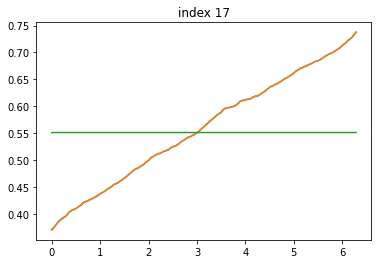

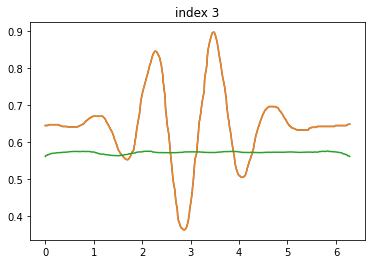

Epoch:     1 / 50;  train loss: 22.94659, val loss: 20.90378


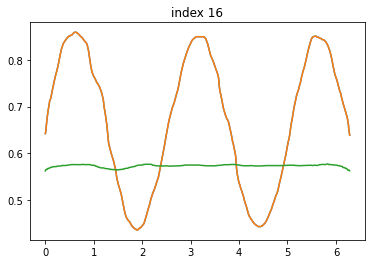

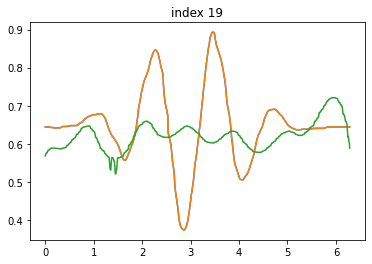

Epoch:     2 / 50;  train loss: 17.64193, val loss: 16.89894


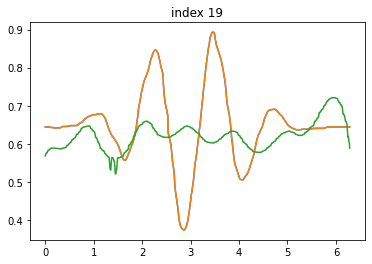

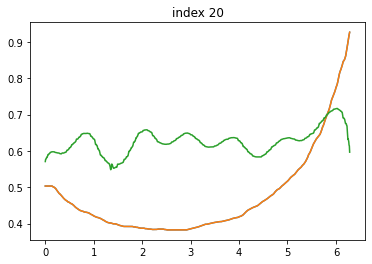

Epoch:     3 / 50;  train loss: 16.82740, val loss: 16.71839


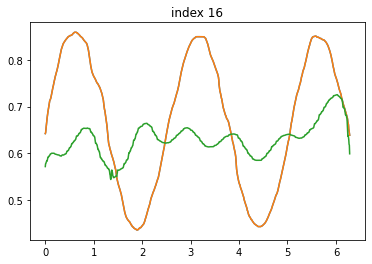

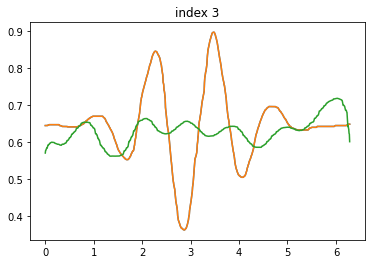

Epoch:     4 / 50;  train loss: 16.40466, val loss: 15.69446


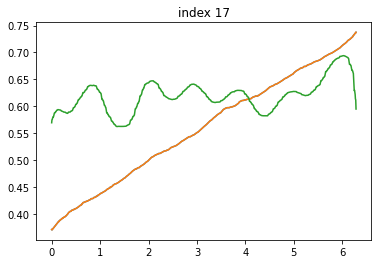

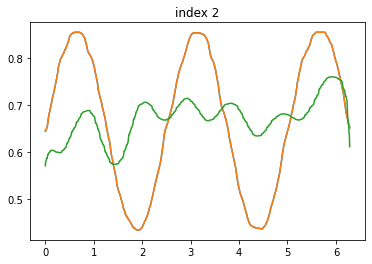

Epoch:     5 / 50;  train loss: 13.52678, val loss: 12.61287


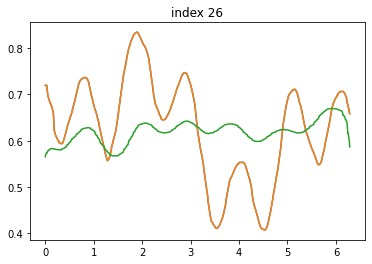

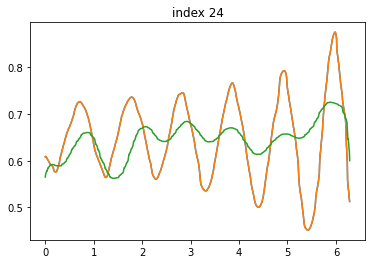

Epoch:     6 / 50;  train loss: 12.53597, val loss: 12.41055


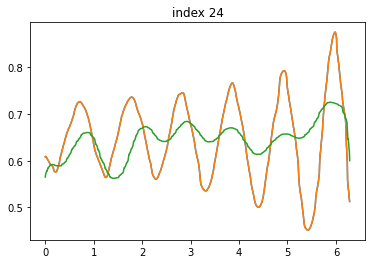

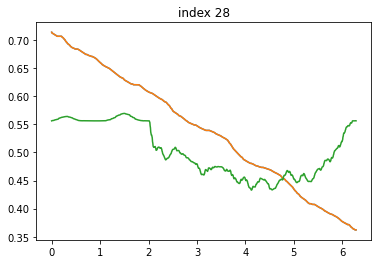

Epoch:     7 / 50;  train loss: 11.49256, val loss: 9.94046


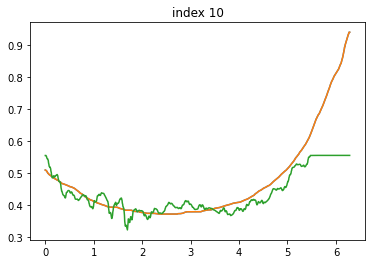

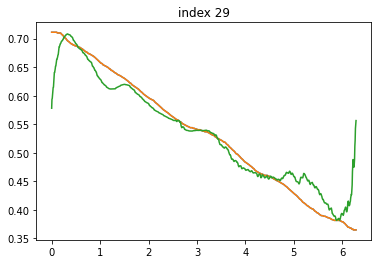

Epoch:     8 / 50;  train loss: 7.64780, val loss: 6.01385


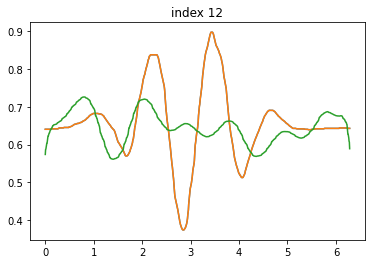

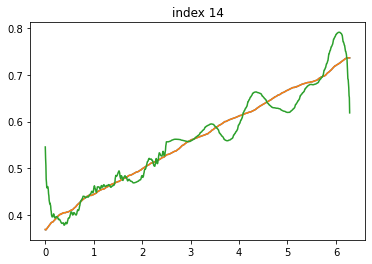

Epoch:     9 / 50;  train loss: 4.82430, val loss: 3.64458


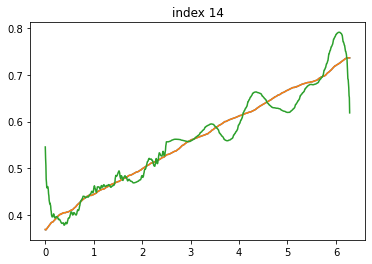

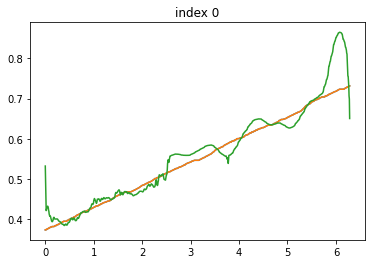

Epoch:    10 / 50;  train loss: 3.10808, val loss: 2.69653


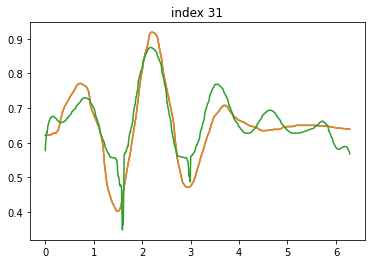

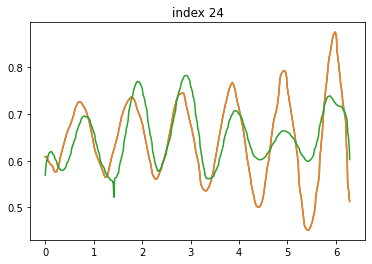

Epoch:    11 / 50;  train loss: 2.37281, val loss: 2.00735


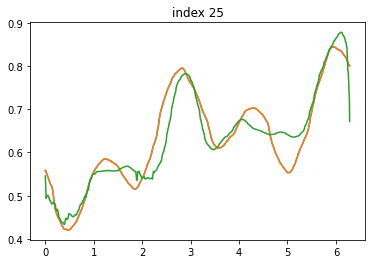

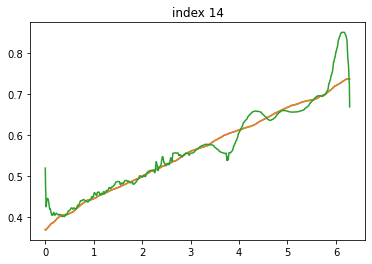

Epoch:    12 / 50;  train loss: 1.71704, val loss: 1.40828


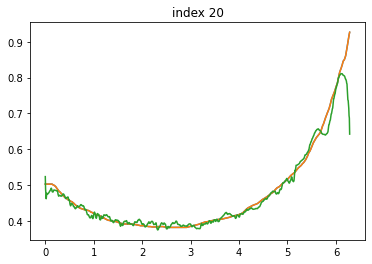

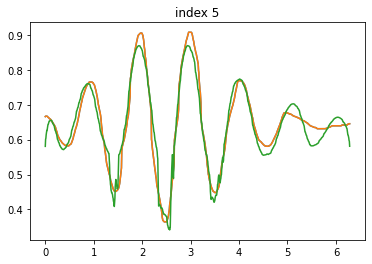

Epoch:    13 / 50;  train loss: 1.09735, val loss: 0.81257


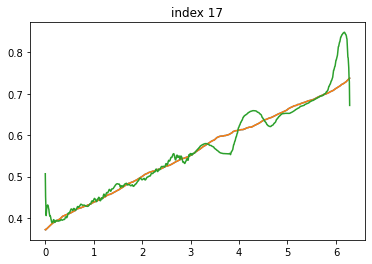

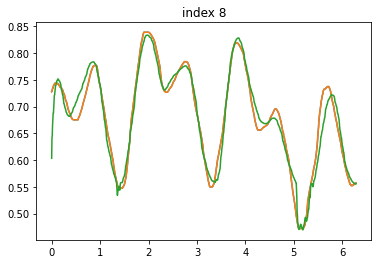

Epoch:    14 / 50;  train loss: 0.65426, val loss: 0.51567


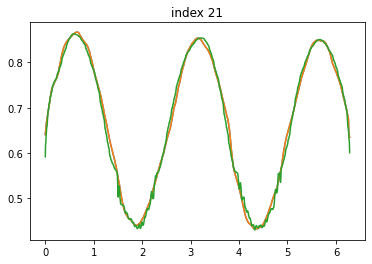

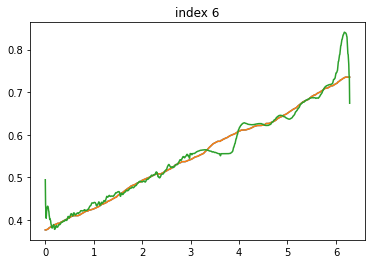

Epoch:    15 / 50;  train loss: 0.44575, val loss: 0.37658


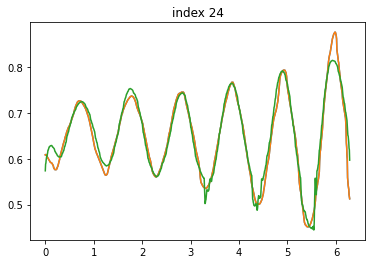

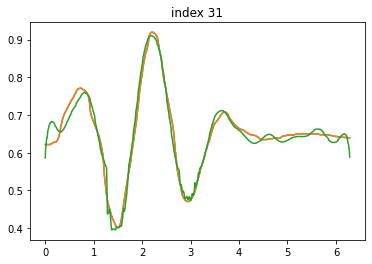

Epoch:    16 / 50;  train loss: 0.34836, val loss: 0.31387


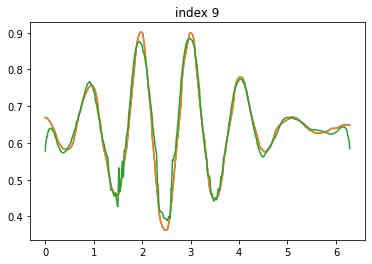

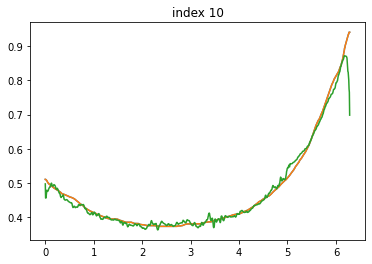

Epoch:    17 / 50;  train loss: 0.29622, val loss: 0.27055


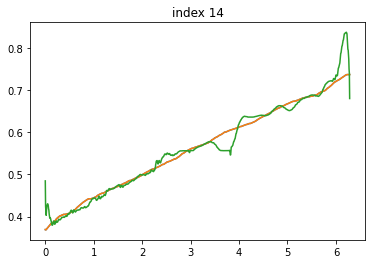

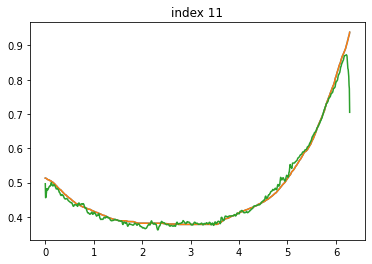

Epoch:    18 / 50;  train loss: 0.25804, val loss: 0.23860


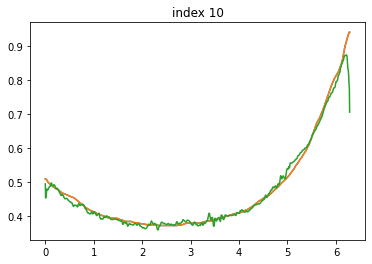

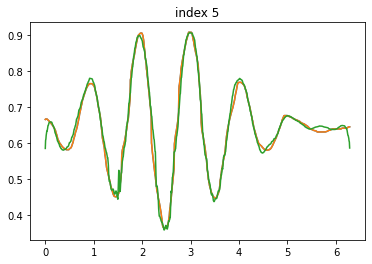

Epoch:    19 / 50;  train loss: 0.23119, val loss: 0.21755


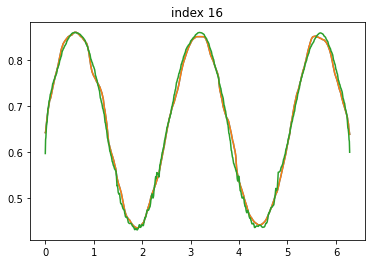

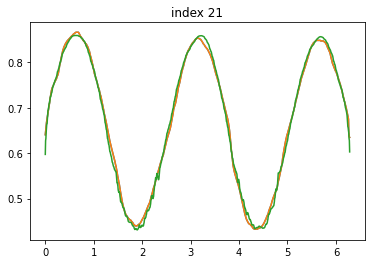

Epoch:    20 / 50;  train loss: 0.20813, val loss: 0.19704


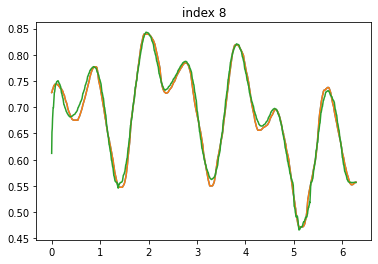

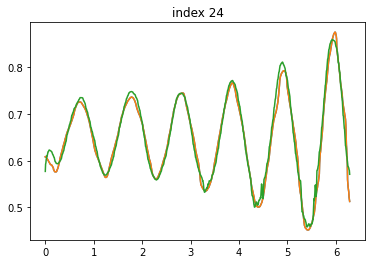

Epoch:    21 / 50;  train loss: 0.19080, val loss: 0.17995


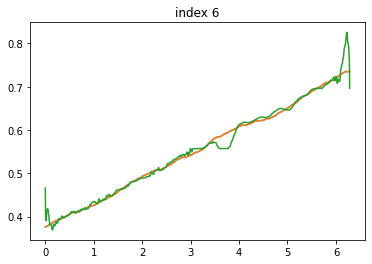

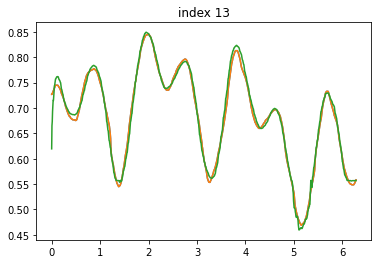

Epoch:    22 / 50;  train loss: 0.17894, val loss: 0.17018


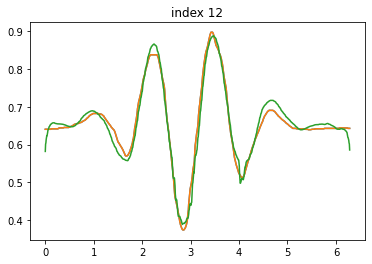

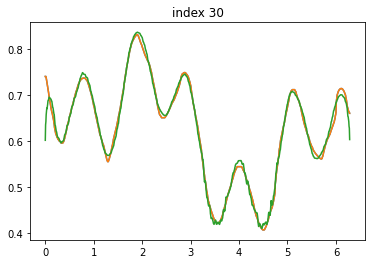

Epoch:    23 / 50;  train loss: 0.16468, val loss: 0.15516


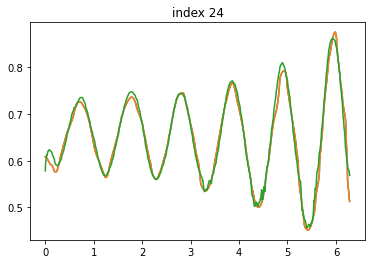

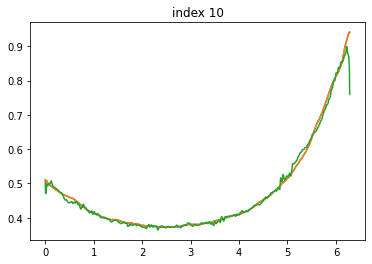

Epoch:    24 / 50;  train loss: 0.15237, val loss: 0.14442


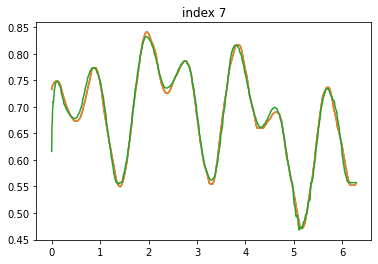

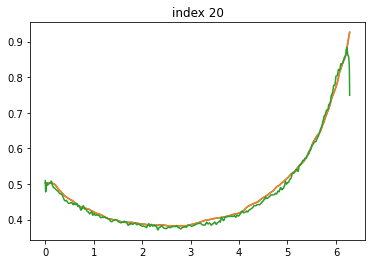

Epoch:    25 / 50;  train loss: 0.14285, val loss: 0.13643


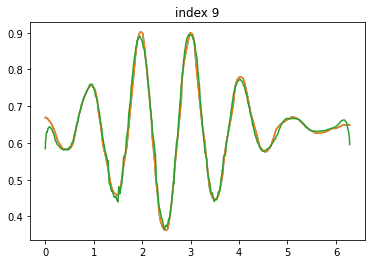

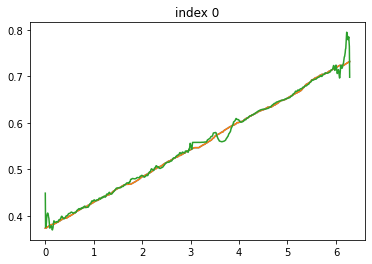

Epoch:    26 / 50;  train loss: 0.13666, val loss: 0.12873


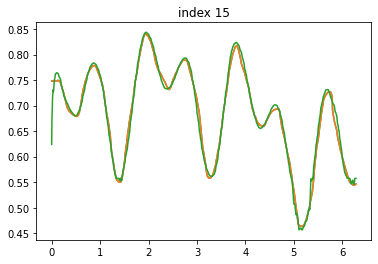

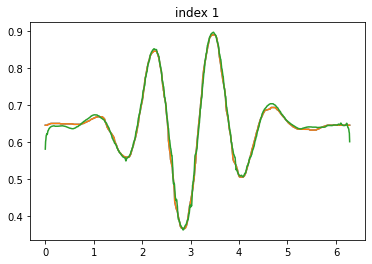

Epoch:    27 / 50;  train loss: 0.12868, val loss: 0.12198


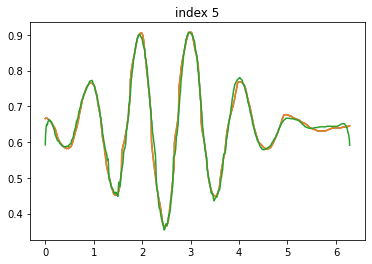

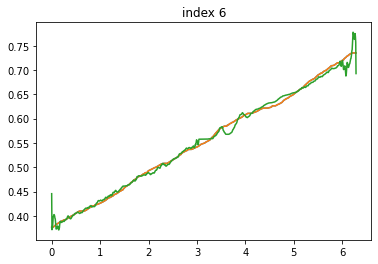

Epoch:    28 / 50;  train loss: 0.12605, val loss: 0.12021


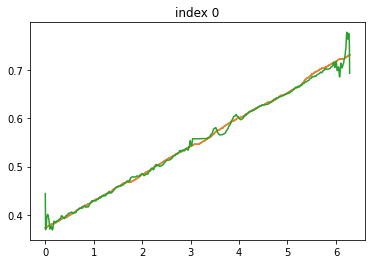

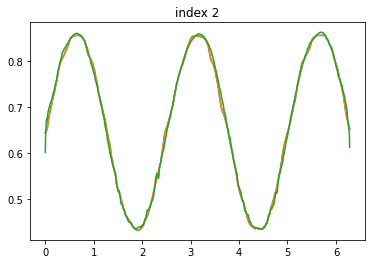

Epoch:    29 / 50;  train loss: 0.12052, val loss: 0.11468


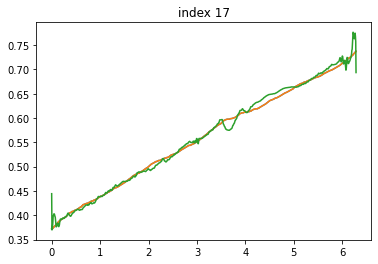

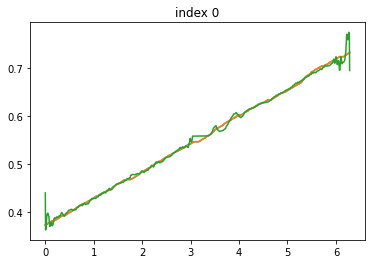

Epoch:    30 / 50;  train loss: 0.11485, val loss: 0.11022


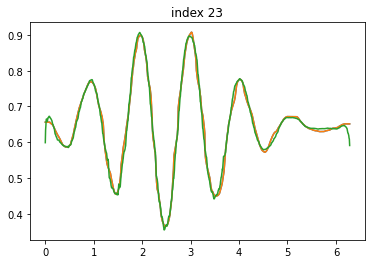

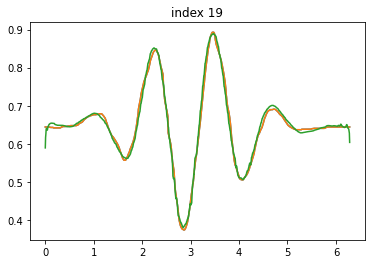

Epoch:    31 / 50;  train loss: 0.11285, val loss: 0.10793


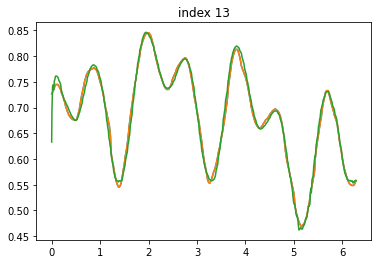

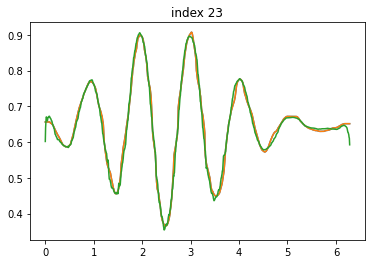

Epoch:    32 / 50;  train loss: 0.10891, val loss: 0.10489


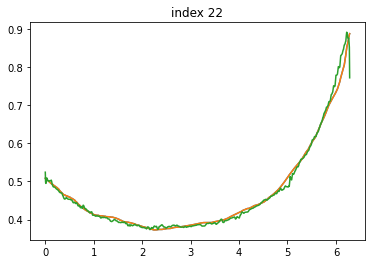

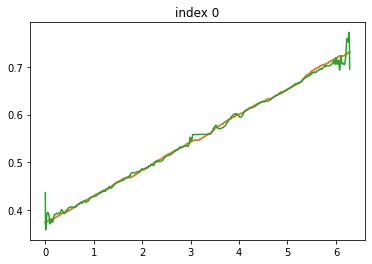

Epoch:    33 / 50;  train loss: 0.10742, val loss: 0.10288


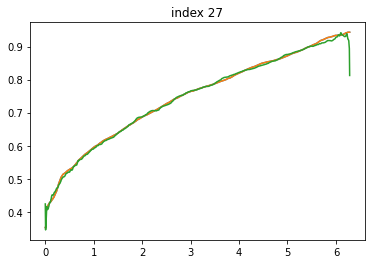

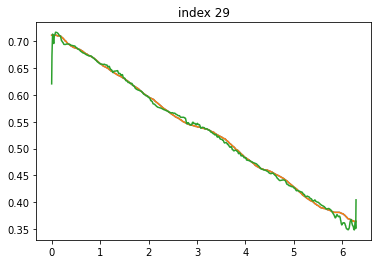

Epoch:    34 / 50;  train loss: 0.10623, val loss: 0.10250


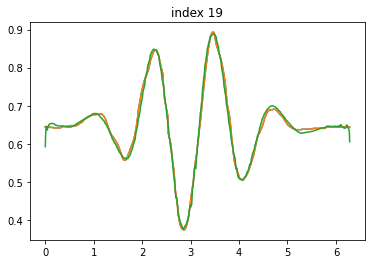

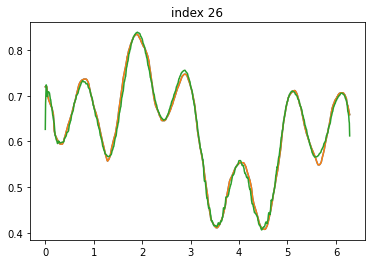

Epoch:    35 / 50;  train loss: 0.10447, val loss: 0.10041


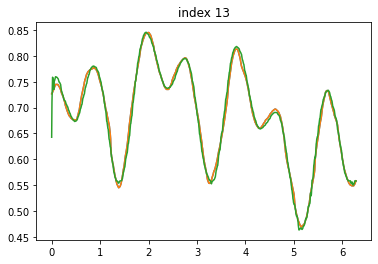

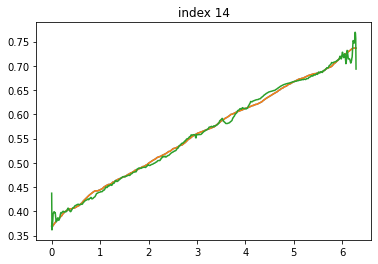

Epoch:    36 / 50;  train loss: 0.10368, val loss: 0.09898


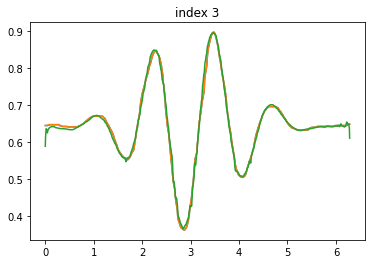

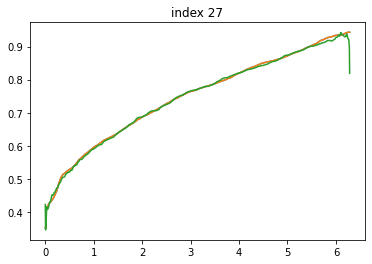

Epoch:    37 / 50;  train loss: 0.10029, val loss: 0.09697


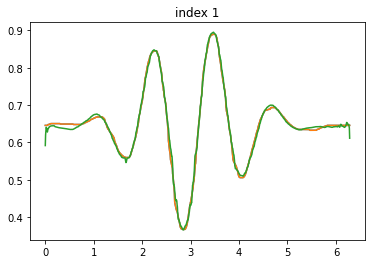

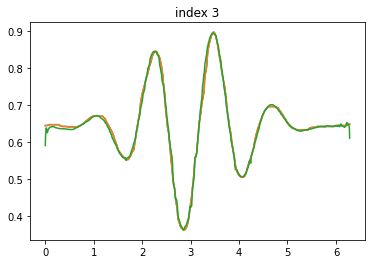

Epoch:    38 / 50;  train loss: 0.09912, val loss: 0.09644


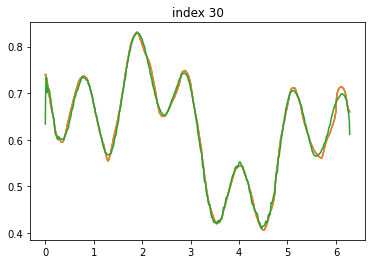

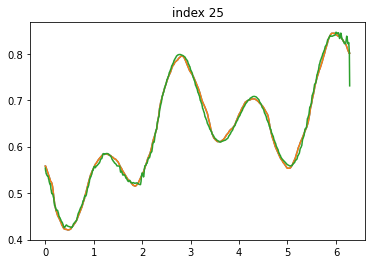

Epoch:    39 / 50;  train loss: 0.09656, val loss: 0.09310


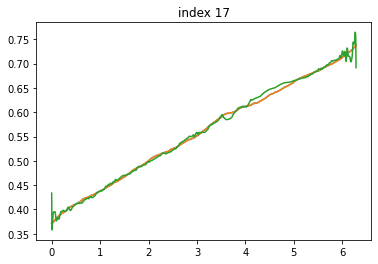

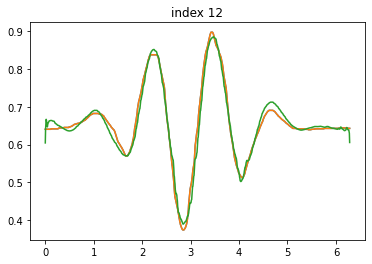

Epoch:    40 / 50;  train loss: 0.09538, val loss: 0.09243


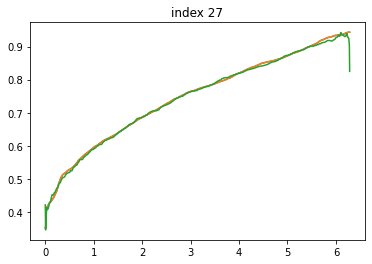

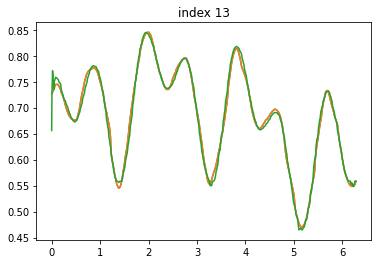

Epoch:    41 / 50;  train loss: 0.09435, val loss: 0.09141


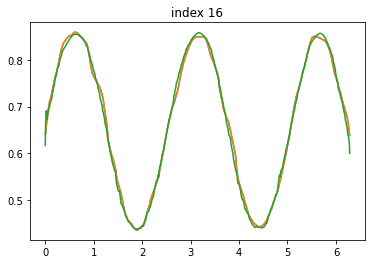

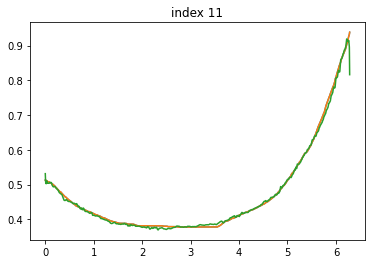

Epoch:    42 / 50;  train loss: 0.09301, val loss: 0.08985


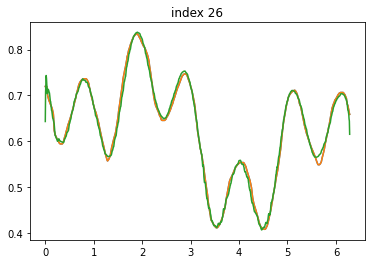

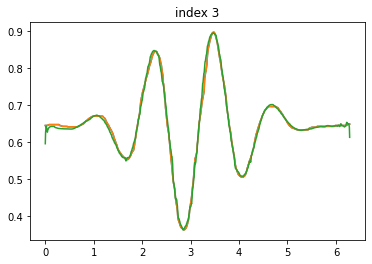

Epoch:    43 / 50;  train loss: 0.09268, val loss: 0.08893


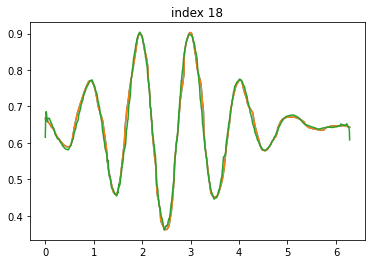

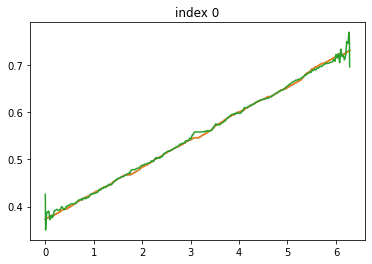

Epoch:    44 / 50;  train loss: 0.09198, val loss: 0.08915


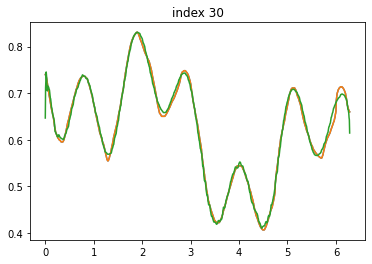

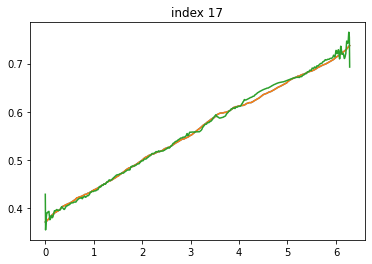

Epoch:    45 / 50;  train loss: 0.09342, val loss: 0.08819


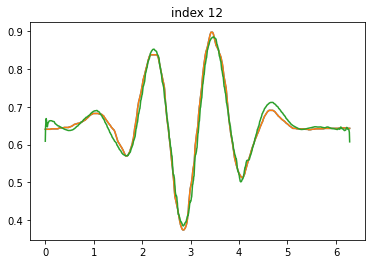

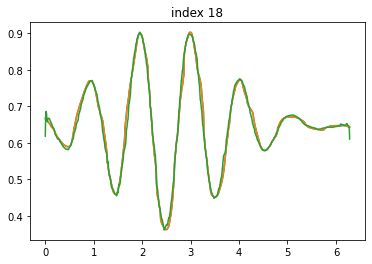

Epoch:    46 / 50;  train loss: 0.09159, val loss: 0.08779


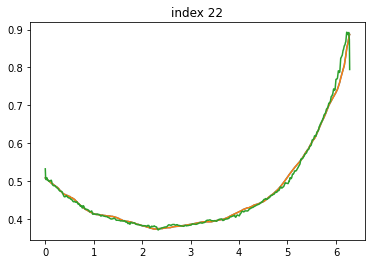

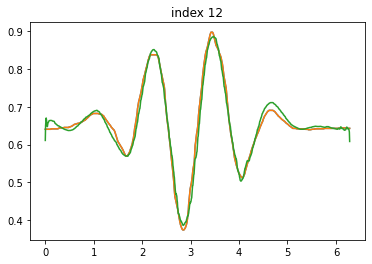

Epoch:    47 / 50;  train loss: 0.08881, val loss: 0.08564


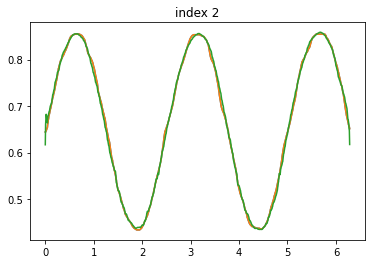

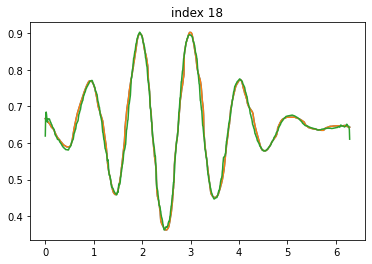

Epoch:    48 / 50;  train loss: 0.09016, val loss: 0.08649


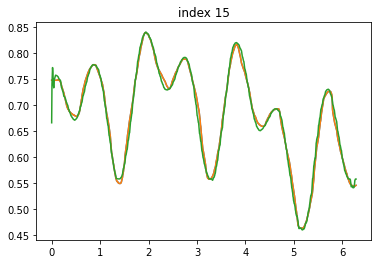

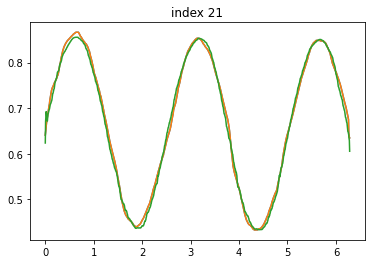

Epoch:    49 / 50;  train loss: 0.09094, val loss: 0.08803


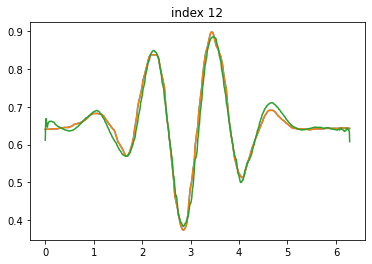

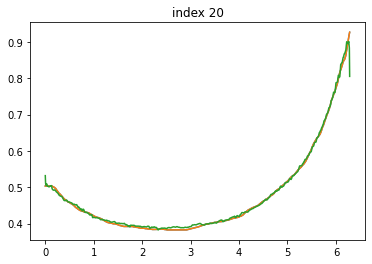

Epoch:    50 / 50;  train loss: 0.08981, val loss: 0.08753


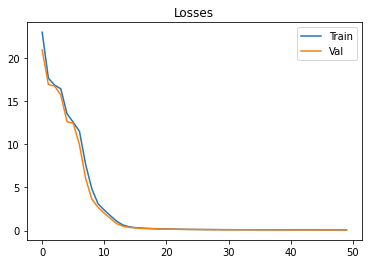

In [78]:
def prepare_dataset_for_ae(df, columncnt, interpolate:bool=True):
    x, drawn_y, real_y = prepare_points(df, columncnt=columncnt, interpolate=interpolate)
    x = [[l] for l in x]
    drawn_y = [[l] for l in drawn_y]
    real_y = [[l] for l in real_y]
    
    x = np.array(x, dtype='float32')
    drawn_y = np.array(drawn_y, dtype='float32')
    real_y = np.array(real_y, dtype='float32')
    
    # input should contain the value on the x axis and the
    # original (real) value
    if interpolate is True:
        X = drawn_y
    else:
        X = np.hstack([x, drawn_y])
        
    
    # the output should contain the drawn value
#     Y = np.hstack([x, drawn_y])
    Y = drawn_y
    print(np.shape(X), np.shape(Y))

    return X, Y

def perform_train(trainx, trainy, testx, testy, columncnt:int, interpolate:bool=True):    
    # there is one channel in X and Y datasets (in_size and out_size)
    # to see how I know there is one channel, check the output shape of prepare_dataset_for_ae
    model = AEModel([2, 4, 8, 16, 32], in_size=trainy.shape[1:], out_size=trainy.shape[1:],  dropout=0)
    display(model)
    
    lr = 0.001
    batch_size = 32
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    bce = nn.BCELoss(reduction='sum')
    mse = nn.MSELoss(reduction='sum')
    
    # dataloaders with batch sizes
    trainx_loader = torch.utils.data.DataLoader(torch.tensor(trainx), batch_size=batch_size, shuffle=False)
    trainy_loader = torch.utils.data.DataLoader(torch.tensor(trainy), batch_size=batch_size, shuffle=False)
    testx_loader = torch.utils.data.DataLoader(torch.tensor(testx), batch_size=batch_size, shuffle=False)
    testy_loader = torch.utils.data.DataLoader(torch.tensor(testy), batch_size=batch_size, shuffle=False)
    
    def loss_function(bce_loss, mu, log_var):
        BCE = bce_loss
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # the final loss is binary cross entropy + kullback leibler divergence
        return BCE + KLD
    
    def fit(model, xdataloader, ydataloader, validation:bool=False):
        i = 0
        total_epoch_loss = 0.0
        for x, y in zip(xdataloader, ydataloader):
            if validation is False:
                optimizer.zero_grad()
            if interpolate is False:
                X = x[:, 0, :]
                x = x[:, 1, :]
                # reshape so it fits (this is *magic*)
                # for details what this does, print its shape before and after
                x = x[:, None, :]
            else:
                X = X_FOR_ALL_FUNC
            reconstruction, mu, log_var = model(x)
            loss = mse(reconstruction, y)
            
            total_epoch_loss += loss

            if i == 0:
                fig = plt.figure()
                ax = fig.gca()
                import random
                _ind = random.randint(0, len(x)-1)
                tmp = x[_ind][0]
                tmp2 = y[_ind][0]
                tmp3 = reconstruction[_ind][0]
                tmp3 = [t.detach().numpy() for t in tmp3]
                X = X if interpolate is True else X[_ind]
                ax.plot(X, tmp)
                ax.plot(X, tmp2)
                ax.plot(X, tmp3)
                ax.set_title(f'index {_ind}')
                plt.show()
                i += 1

            if validation is False:
                loss.backward()
                optimizer.step()
        total_epoch_loss /= len(xdataloader.dataset)
        return total_epoch_loss

    epochs = 50
    train_losses, val_losses = [], []
    for _epoch_idx in range(epochs):
        # switch model to training mode
        model.train()
        train_epoch_loss = fit(model, trainx_loader, trainy_loader, False)
        train_losses.append(train_epoch_loss)
        
        # and now val mode
        model.eval()
        with torch.no_grad():
            val_epoch_loss = fit(model, testx_loader, testy_loader, True)
            val_losses.append(val_epoch_loss)
        
        print(f'Epoch: {_epoch_idx+1:5} / {epochs};',
              f' train loss: {train_epoch_loss:.5f}, val loss: {val_epoch_loss:.5f}')
    
    def plot_training_stats():
        fig = plt.figure()
        ax = fig.gca()
        ax.plot(range(epochs), [loss.detach().numpy() for loss in train_losses], label='Train')
        ax.plot(range(epochs), [loss.detach().numpy() for loss in val_losses], label='Val')
        ax.set_title('Losses')
        ax.legend()
        plt.show()
    
    plot_training_stats()
    return model

def do_everything(columncnt, interpolate:bool=True):
    df_to_use = df.query('ProjectionName == "Cartesian"')
    trainx, trainy = prepare_dataset_for_ae(df_to_use, columncnt, interpolate=interpolate)
    testx, testy   = prepare_dataset_for_ae(df_to_use, columncnt, interpolate=interpolate)
    model = perform_train(trainx, trainy, testx, testy, interpolate=interpolate, columncnt=columncnt)

    return model, (trainx, trainy, testx, testy)

# make sure columncnt is divisible 5 times by 2!!!
columncnt = len(X_FOR_ALL_FUNC)
ae_model, datasets = do_everything(columncnt, interpolate=True)

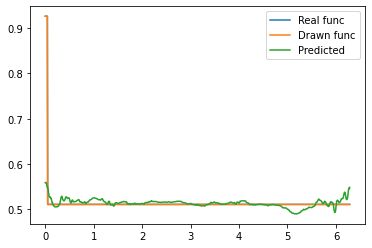

In [94]:
def draw_prediction(testx, testy, model, columncnt):
    fig = plt.figure()
    ax = fig.gca()
    import random
    _ind = random.randint(0, len(testx))
    real_func_x = X_FOR_ALL_FUNC
    real_func_y = testx[_ind][0]
    ax.plot(real_func_x, real_func_y, label='Real func')
    
    drawn_func_x = X_FOR_ALL_FUNC
    drawn_func_y = testy[_ind][0]
    ax.plot(drawn_func_x, drawn_func_y, label='Drawn func')
    
    model.eval()
    with torch.no_grad():
        predicted, _, _ = model(torch.tensor(testx))
        
#         pred_func_x = predicted[_ind, :columncnt]
        pred_func_x = X_FOR_ALL_FUNC
        pred_func_y = predicted[_ind][0]
        ax.plot(pred_func_x, pred_func_y, label='Predicted')
    ax.legend()
    plt.show()

draw_prediction(datasets[2], datasets[3], ae_model, columncnt)

# Predicting the time needed to draw a curve using CNN
TF/Keras: https://towardsdatascience.com/house-prices-prediction-using-deep-learning-dea265cc3154


,Length,Kappa
0,10.765825,0.000000
1,17.773629,3.250856
2,18.647263,13.064420
3,17.972323,12.026278
4,17.033850,8.823529
5,15.427970,10.012886
6,12.034755,1.401196
7,18.421721,3.317192
8,18.379158,23.673901
9,26.805470,22.631483


0      8.971129
1     18.910516
2     25.171086
3     25.687566
4     21.656811
5     19.746401
6     11.295871
7     21.313062
8     27.944153
9     39.304494
10    33.054325
11    35.934397
Name: Drawing time, dtype: float64

,Length,Kappa
0,17.299539,3.490659
1,11.393393,0.834063
2,18.251077,21.282024
3,24.192548,23.796681
4,17.030233,10.256300
5,16.193773,10.927319
6,10.765825,0.000000
7,16.941990,3.517750
8,14.173052,12.004836
9,15.781794,13.257499


0     19.873787
1      9.985332
2     26.915240
3     35.267432
4     21.860873
5     20.785790
6      9.053880
7     18.561387
8     19.506554
9     21.881450
10    30.144331
11    36.108736
Name: Drawing time, dtype: float64

TimePredictionModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Linear(in_features=8, out_features=1, bias=True)
  )
)

Epoch:     1 / 100;  train loss: 96.26841, val loss: 90.87060
Epoch:     2 / 100;  train loss: 80.78091, val loss: 59.48949
Epoch:     3 / 100;  train loss: 29.37750, val loss: 23.97727
Epoch:     4 / 100;  train loss: 14.81526, val loss: 15.07841
Epoch:     5 / 100;  train loss: 11.04048, val loss: 14.58319
Epoch:     6 / 100;  train loss: 9.70352, val loss: 6.55929
Epoch:     7 / 100;  train loss: 7.81337, val loss: 6.91782
Epoch:     8 / 100;  train loss: 7.34642, val loss: 6.43281
Epoch:     9 / 100;  train loss: 6.35113, val loss: 7.61922
Epoch:    10 / 100;  train loss: 6.03595, val loss: 5.15845
Epoch:    11 / 100;  train loss: 6.35647, val loss: 6.67129
Epoch:    12 / 100;  train loss: 6.15932, val loss: 5.16912
Epoch:    13 / 100;  train loss: 6.39737, val loss: 6.83020
Epoch:    14 / 100;  train loss: 5.69992, val loss: 7.47721
Epoch:    15 / 100;  train loss: 5.40014, val loss: 5.55466
Epoch:    16 / 100;  train loss: 6.02909, val loss: 5.36170
Epoch:    17 / 100;  train los

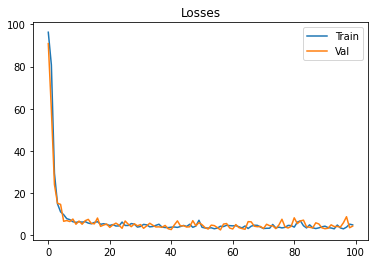

In [326]:
class TimePredictionModel(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes: typing.List[int],
        in_size:int,
        dropout:float=0.3
    ):
        super().__init__()
        
        _all_layers = []
        for _lyr_size in hidden_layer_sizes:
            _all_layers.append(nn.Linear(in_features=in_size, out_features=_lyr_size))
            _all_layers.append(nn.LeakyReLU(inplace=True))
            
            if(dropout > 0):
                _all_layers.append(nn.Dropout(p=dropout))
            in_size = _lyr_size
        
        # at the end, there is a layer with only one neuron: which is the output
        # and the output is the predicted time
        _all_layers.append(nn.Linear(in_features=in_size, out_features=1))
        self.layers = nn.Sequential(*_all_layers)
    
    def forward(self, x):
        x = self.layers(x)
        return x

def prepare_dataset_for_time_pred(df: pd.DataFrame, include_fig_embeddings:bool=False):
    """Returns X any Y (as tuple, in respective order)"""
    
    # first of all, find unique figures (through FigureID and Projection)
    figureids = df['FigureID'].unique()
    projectionids = df['Projection'].unique()
    
    data_for_nn = pd.DataFrame(columns=['FigureID', 'Projection', 'Length', 'Kappa', 'Drawing time'])
    embeddings_arr = []
    
    for figureid in figureids:
        for projectionid in projectionids:
            all_drawings_for_this_func = df.query(
                f'FigureID == {figureid} and ' +
                f'Projection == {projectionid}'
            )
            # find the average drawing time
            avg_draw_time = all_drawings_for_this_func['Drawing time'].mean()
            if(len(all_drawings_for_this_func) < 1):
                # if no figures found, just continue onto the next
                continue
            # all of these entries have the same length (it's the same function)
            # so just take the first one
            _idx = all_drawings_for_this_func.index[0]
            length = all_drawings_for_this_func['Length'].loc[_idx]
            kappa = all_drawings_for_this_func['Kappa'].loc[_idx]
            
            if include_fig_embeddings is True:
                # obtain embeddings for this figure from the CAE model
                _, real_func = prepare_dataset_for_ae(all_drawings_for_this_func, len(X_FOR_ALL_FUNC))
                real_func = torch.tensor(real_func)
                ae_model.eval()
                with torch.no_grad():
                    embedding, _ = ae_model.get_latent(real_func)
                    embedding = np.array(embedding)
                    # this contains embeddings for ALL of the drawings
                    # i.e. each entry is a single drawing
                    for e in embedding:
                        embeddings_arr.append(e)
                for _idx_drwg in all_drawings_for_this_func.index:
                    # each row contains the drawing time of each drawing
                    # this will be coupled with each specific drawing
                    # i.e. the drawing times are not aggregated but used separately
                    drwg = all_drawings_for_this_func.loc[_idx_drwg]
                    data_for_nn.loc[len(data_for_nn)] = [
                        figureid, projectionid, length, kappa, drwg['Drawing time']
                    ]
            else:
                data_for_nn.loc[len(data_for_nn)] = [figureid, projectionid, length, kappa, avg_draw_time]

    # no need to scale the data (the model works without it), but this can be done if you want to
#     data_for_nn['Length'] = data_for_nn['Length'] / 30
#     data_for_nn['Kappa'] = data_for_nn['Kappa'] / 30
    
    if include_fig_embeddings is True:
        # then this is an array of embeddings
        # where each entry is an embedding for a figure
        # now we have to join the dataframes with len/kappa and this
        embeddings_arr = prep.minmax_scale(embeddings_arr)
        print(np.shape(embeddings_arr))
        # the way we join them is by pairwise multiplication:
        # each embiedding is multiplied by length
        # and each embedding is multiplied by kappa
        # and the resulting two arrays are concatenated
        # sidenote: embeddings_arr is an m x n matrix, where there are m curves
        # and n is the length of a single embedding, WHILE data_for_nn has length m
        # because there are m curves
        embeddings_len = [emb * l for emb, l in zip(embeddings_arr, data_for_nn['Length'])]
        embeddings_kap = [emb * k for emb, k in zip(embeddings_arr, data_for_nn['Kappa'])]
        
        data_for_nn = pd.concat(
            [data_for_nn, pd.DataFrame(embeddings_len), pd.DataFrame(embeddings_kap)], 
            axis=1
        )
        # drop Length and Kappa because they are "incorporated" into embeddings now
        data_for_nn.drop(['Kappa', 'Length'], axis=1, inplace=True)
#         display(data_for_nn)
    
    X = data_for_nn.drop(['FigureID', 'Projection', 'Drawing time'], axis=1)
    Y = data_for_nn['Drawing time']
    display(X)
    display(Y)
    
    X = np.array(X, dtype='float32')
    Y = np.array(Y, dtype='float32')
    return X, Y

def do_everything_for_time_pred(df, include_fig_embeddings:bool=False):
    trainx, trainy = prepare_dataset_for_time_pred(df.query('TestIndex == 0').copy(), include_fig_embeddings)
    testx, testy = prepare_dataset_for_time_pred(df.query('TestIndex == 1').copy(), include_fig_embeddings)
    
    model = TimePredictionModel(hidden_layer_sizes=[128, 64, 32, 16, 8], in_size=np.shape(trainx)[1], dropout=0)
    display(model)
    
    def loss_func(y, y_predicted, reduction='sum'):
        rmspe = (torch.sqrt(torch.mean(torch.square((y_predicted - y) / y_predicted)))) * 100
        if(reduction == 'sum'):
            rmspe = torch.sum(rmspe)
        else:
            rmspe = torch.mean(rmspe)
        return rmspe
        
    lr = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    epochs = 100
    batch_size = 1
    
    trainx_loader = torch.utils.data.DataLoader(torch.tensor(trainx), batch_size=batch_size)
    trainy_loader = torch.utils.data.DataLoader(torch.tensor(trainy), batch_size=batch_size)
    testx_loader = torch.utils.data.DataLoader(torch.tensor(testx), batch_size=batch_size)
    testy_loader = torch.utils.data.DataLoader(torch.tensor(testy), batch_size=batch_size)
    
    def fit(model, xdataloader, ydataloader, optimizer, loss_func, validation:bool=False):
        total_epoch_loss = 0.0
        for x, y in zip(xdataloader, ydataloader):
            if validation is False:
                optimizer.zero_grad()
            output = model(x)
            loss = loss_func(output, y)
            
            total_epoch_loss += loss

            if validation is False:
                loss.backward()
                optimizer.step()
        total_epoch_loss /= len(xdataloader.dataset)
        return total_epoch_loss
    
    train_losses, val_losses = [], []
    for _epoch_idx in range(epochs):
        # switch model to training mode
        model.train()
        train_epoch_loss = fit(model, trainx_loader, trainy_loader, optimizer, loss_func, False)
        train_losses.append(train_epoch_loss)
        
        # and now val mode
        model.eval()
        with torch.no_grad():
            val_epoch_loss = fit(model, testx_loader, testy_loader, optimizer, loss_func, True)
            val_losses.append(val_epoch_loss)
        
        print(f'Epoch: {_epoch_idx+1:5} / {epochs};',
              f' train loss: {train_epoch_loss:.5f}, val loss: {val_epoch_loss:.5f}')
    
    def plot_training_stats():
        fig = plt.figure()
        ax = fig.gca()
        ax.plot(range(epochs), [loss.detach().numpy() for loss in train_losses], label='Train')
        ax.plot(range(epochs), [loss.detach().numpy() for loss in val_losses], label='Val')
        ax.set_title('Losses')
        ax.legend()
        plt.show()
        
    plot_training_stats()

    return model, (trainx, trainy, testx, testy)

time_pred_model, time_pred_datasets = do_everything_for_time_pred(
    df.query('Device == "Mouse"'),
    include_fig_embeddings=False
)

Predicted time: 18.275497 ::: Actual time: 19.873787
Predicted time: 10.094723 ::: Actual time: 9.9853325
Predicted time: 28.006887 ::: Actual time: 26.91524
Predicted time: 36.60504 ::: Actual time: 35.267433
Predicted time: 22.059248 ::: Actual time: 21.860872
Predicted time: 21.616404 ::: Actual time: 20.78579
Predicted time: 8.583556 ::: Actual time: 9.05388
Predicted time: 17.952965 ::: Actual time: 18.561386
Predicted time: 20.24343 ::: Actual time: 19.506554
Predicted time: 22.51412 ::: Actual time: 21.88145
Predicted time: 33.534645 ::: Actual time: 30.144331
Predicted time: 37.22362 ::: Actual time: 36.108734


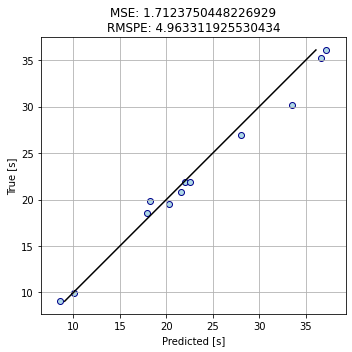

(144, 2)


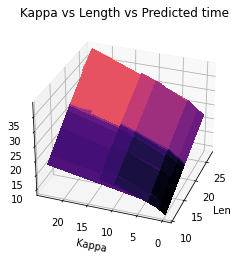

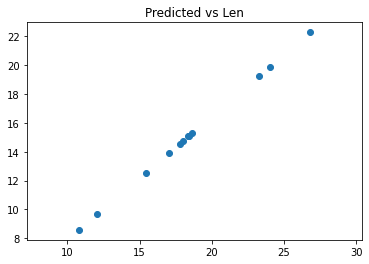

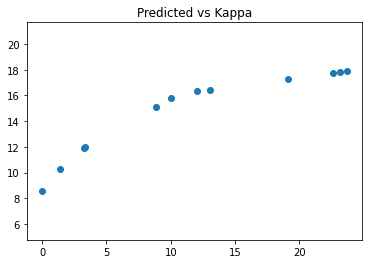

(144, 2)


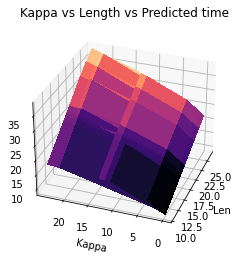

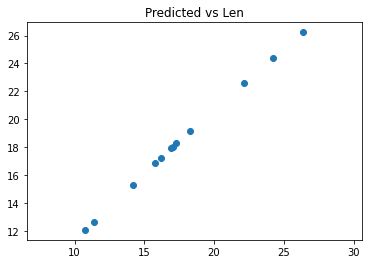

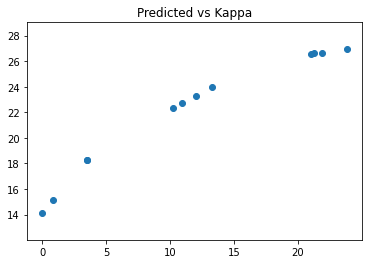

(100, 2)


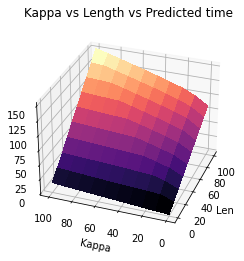

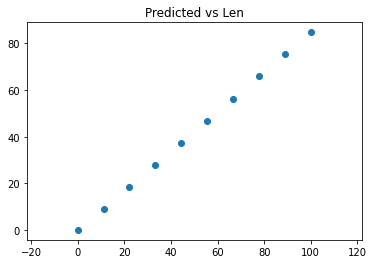

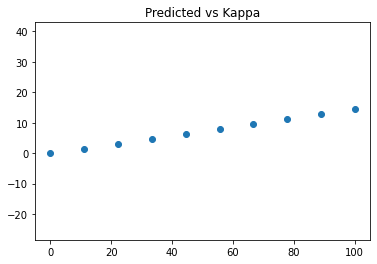

In [327]:
def plot_predicted_vs_true(model, x, y_true):
    fig = plt.figure(tight_layout=True, figsize=(5,5))
    ax = fig.gca()
    ax.axis('equal')
    ax.grid(True)

    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(x))
        y_pred = y_pred.detach().numpy()
        y_pred = np.ravel(y_pred)
        for p, t in zip (y_pred, y_true):
            print('Predicted time:', p, '::: Actual time:', t)
        rmspe = (np.sqrt(np.mean(np.square((y_pred - y_true) / y_pred)))) * 100
        from sklearn.metrics import mean_squared_error
        mse = mean_squared_error(y_pred, y_true)
        line = np.linspace(np.min(y_true),np.max(y_true))
        ax.scatter(y_pred, y_true, color='lightblue', edgecolors='darkblue')
        ax.plot(line, line, color='black')
        ax.set_title(f'MSE: {mse}\nRMSPE: {rmspe}')
        ax.set_xlabel('Predicted [s]')
        ax.set_ylabel('True [s]')
    plt.show()

plot_predicted_vs_true(time_pred_model, time_pred_datasets[2], time_pred_datasets[3])
# plot_predicted_vs_true(time_pred_model, [[0., 0.], [0., 1.], [0., 2.], [0., 3.]], [0.,1.,2.,3.])

# for creating interactive 3d plots
# %matplotlib widget

def plot_3d_kappa_vs_len_vs_pred(model, kappa, length):
    # pair each kappa with each length to get a full grid
    x = []
    for k in kappa:
        for l in length:
            x.append([l, k])
    print(np.shape(x))
    x = torch.tensor(x)
    model.eval()
    
    from mpl_toolkits.mplot3d import Axes3D
    
    with torch.no_grad():
        pred = model(x)
        pred = np.array(pred)
        pred = np.reshape(pred, (len(length), len(kappa)))
#         fig = plt.figure()
#         ax = Axes3D(fig, auto_add_to_figure=False)
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        X, Y = np.meshgrid(length, kappa)
        surf = ax.plot_surface(X,Y, pred, cmap='magma',
                       linewidth=0, antialiased=False)
        ax.set_ylabel('Kappa')
        ax.set_xlabel('Len')
        angle=200
        ax.view_init(30, angle)
        ax.set_title('Kappa vs Length vs Predicted time')
        plt.show()
        
        plt.figure()
        plt.axis('equal')
        plt.scatter(length, pred[0])
#         print(length)
        plt.title('Predicted vs Len')
        plt.show()
        plt.figure()
#         print(kappa)
        plt.scatter(kappa, pred[:, 0])
        plt.title('Predicted vs Kappa')
        plt.axis('equal')
        plt.show()


def plot_time_predicted_for_imaginary_values(model, n_imaginary_points=10):
    # to test what the model has learned, generate a 3d plot how much time it takes depending on kappa and len
    kappa = np.linspace(0, 100, num=n_imaginary_points, dtype='float32')
    length = np.linspace(0, 100, num=n_imaginary_points, dtype='float32')
#     kappa = np.zeros(n_imaginary_points, dtype='float32')
    return plot_3d_kappa_vs_len_vs_pred(model, kappa, length)

plot_3d_kappa_vs_len_vs_pred(time_pred_model, time_pred_datasets[0][:,1],  time_pred_datasets[0][:,0])
plot_3d_kappa_vs_len_vs_pred(time_pred_model, time_pred_datasets[2][:,1],  time_pred_datasets[2][:,0])
plot_time_predicted_for_imaginary_values(time_pred_model)
%matplotlib inline

# Splitting the curve into N parts, calculating the curve and length of each part, then predicting the time needed

In [194]:
def calculate_riemann_integral(f, x0, x1, numpoints):
    integral_approx = 0
    # distance between two points (will be very small)
    delta = (x1 - x0) / numpoints
    i = 0
    for i in range(numpoints):
        # put integral_approx calculation inside try-except
        # in case we get "division by zero" exception.
        if(i % (numpoints / 10) == 0):
            # this condition is meant to represent a "loading bar"
            # it will print the current percentage of points processed
            # print(round(x0 / x1, 3) * 100, "%  done")
            pass
        try:
            # Riemann sum
            integral_approx += (f(x0) * delta)
        except Exception as e:
            # this might, on very rare occassions, be
            # "division by zero"
            print(e)
        finally:
            x0 += delta
    return integral_approx
    
    
def get_function_length_and_kappa_by_parts(
    figureid:int, projectionid:int, x0:float=None, x1:float=None, n_parts:int=None, x=None):
    """This returns parts_len, parts_kappa"""
    fp = FunctionProvider()
        
    # now, split the curve into n_parts and find kappa and length for each one
    difficulty = int(figureid / 2)
    task = int(figureid % 2)
    # the test index is the same because these are all the same curves
    test = projectionid

    # get the sympy equations which describe kappa and len
    kappa = fp.get_function_curvature(difficulty, task, test)
    length = fp.get_function_length(difficulty, task, test)

    # this is for getting the real length of individual parts
    import display_properties
    if(test in [0, 1]): # this means the plot is Cartesian
        length = length * display_properties.CARTESIAN_UNIT_LENGTH_IN_INCH
    else:
        length = length * display_properties.POLAR_UNIT_LENGTH_IN_INCH

#     x0 = display_properties.X_RANGE['start']
#     x1 = display_properties.X_RANGE['end']
    if x is None:
        x = np.linspace(x0, x1, num=n_parts+1)
    else:
        n_parts = len(x) - 1

    import sympy as sp
    # the variable with which to express kappa and len
    x_symbol = sp.Symbol("x")
    # lambdify both function so we can calculate what's between them
    length = sp.lambdify(x_symbol, length, "numpy")
    kappa = sp.lambdify(x_symbol, kappa, "numpy")

    parts_kappa = []
    parts_len = []
    parts_of_this_function = []

    for i in range(n_parts):
        k = calculate_riemann_integral(kappa, x[i], x[i+1], 100)
        l = calculate_riemann_integral(length, x[i], x[i+1], 100)
        parts_kappa.append(k)
        parts_len.append(l)
    return parts_len, parts_kappa


class TimePredictionFromSlicedCurves:
    
    def prepare_data(self, df: pd.DataFrame, n_parts:int, verbose:bool=False):
        # first of all, find unique figures (through FigureID and Projection)
        figureids = df['FigureID'].unique()
        projectionids = df['Projection'].unique()
        devices = df['Device'].unique()
        
        fp = FunctionProvider()

        data_for_nn = pd.DataFrame(columns=['FigureID', 'Projection', 'Device', 'Drawing time', 'Time Var'])
        # this will be a 2d array
        all_parts_of_all_functions = []
        
        for figureid in figureids:
            for projectionid in projectionids:
                for device in devices:
                    # encode device to be either 0 (if mouse) or 1 if(graphic tablet)
                    deviceid = 0 if device == "Mouse" else 1
                    
                    all_drawings_for_this_func = df.query(
                        f'FigureID == {figureid} and ' +
                        f'Projection == {projectionid} and ' +
                        f'Device == "{device}"'
                    )
                    # counts how many new items have been added to data_for_nn in this iteration
                    elements_added_to_data_for_nn = 0

                    if(len(all_drawings_for_this_func) < 1):
                        # if no figures found, just continue onto the next
                        continue

    #                 # find the average drawing time                    
                    avg_draw_time = all_drawings_for_this_func['Drawing time'].mean()
                    var_draw_time = all_drawings_for_this_func['Drawing time'].var()
                    median_draw_time = all_drawings_for_this_func['Drawing time'].median()
                    data_for_nn.loc[len(data_for_nn)] = [
                        figureid, projectionid, deviceid, avg_draw_time, var_draw_time
                    ]
                    elements_added_to_data_for_nn += 1

#                     for _idx in all_drawings_for_this_func.index:
#                         # instead of avg drawing time, we can use ALL drawings
#                         entry = all_drawings_for_this_func.loc[_idx]
#                         data_for_nn.loc[len(data_for_nn)] = [
#                             figureid, projectionid, deviceid, entry['Drawing time'], 0
#                         ]
#                         elements_added_to_data_for_nn += 1

                    import display_properties
                    parts_len, parts_kappa = get_function_length_and_kappa_by_parts(
                        projectionid=projectionid,
                        figureid=figureid,
                        n_parts=n_parts,
                        x0=display_properties.X_RANGE['start'],
                        x1=display_properties.X_RANGE['end']
                    )
                    parts_kappa = np.abs(parts_kappa)
#                     parts_of_this_function = np.hstack([parts_len, parts_kappa])
                    parts_of_this_function = []
                    for k, l in zip(parts_kappa, parts_len):
                        parts_of_this_function.append(l)
                        parts_of_this_function.append(k)

                    for _ in range(elements_added_to_data_for_nn):
                        all_parts_of_all_functions.append(parts_of_this_function)

        data_for_nn = pd.concat(
            [data_for_nn, pd.DataFrame(all_parts_of_all_functions)], 
            axis=1
        )
#         display(data_for_nn)
            
        X = data_for_nn.drop(['FigureID', 'Projection', 'Drawing time', 'Time Var'], axis=1)
        Y = data_for_nn[['Drawing time']]
        if verbose:
            display(X)
            display(Y)

        X = np.array(X, dtype='float32')
        Y = np.array(Y, dtype='float32')
        X = np.expand_dims(X, 1) # this is necessary for conv network
        
        return X, Y, data_for_nn
    
    def train(
        self,
        df: pd.DataFrame,
        layer_sizes:typing.List[int],
        n_parts:int=10,
        epochs:int=100,
        lr:float=0.001,
        dropout:float=0.2,
        verbose:bool=False
    ):
        trainx, trainy, self.train_df = self.prepare_data(
            df.query('TestIndex == 0').copy(), n_parts, verbose=verbose)
        testx, testy, self.test_df = self.prepare_data(
            df.query('TestIndex == 1').copy(), n_parts, verbose=verbose)
        BATCH_SIZE = 20
        
        model = self.TimePredictionModel(
            layer_sizes=layer_sizes,in_size=trainx.shape[2], out_size=trainy.shape[1], dropout=dropout
        )
        if verbose:
            print(model)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        trainx_loader = torch.utils.data.DataLoader(torch.tensor(trainx), batch_size=BATCH_SIZE)
        trainy_loader = torch.utils.data.DataLoader(torch.tensor(trainy), batch_size=BATCH_SIZE)
        testx_loader = torch.utils.data.DataLoader(torch.tensor(testx), batch_size=BATCH_SIZE)
        testy_loader = torch.utils.data.DataLoader(torch.tensor(testy), batch_size=BATCH_SIZE)
        
        def fit(model, xdataloader, ydataloader, optimizer, loss_func, validation:bool=False):
            total_epoch_loss = 0.0
            for x, y in zip(xdataloader, ydataloader):
                if validation is False:
                    optimizer.zero_grad()
                output = model(x)
                loss = loss_func(output, y)

                total_epoch_loss += loss

                if validation is False:
                    loss.backward()
                    optimizer.step()
#             total_epoch_loss /= len(xdataloader.dataset)
            return total_epoch_loss

        train_losses, val_losses = [], []
        for _epoch_idx in range(epochs):
            # switch model to training mode
            model.train()
            train_epoch_loss = fit(model, trainx_loader, trainy_loader, optimizer, model.loss_func, False)
            train_losses.append(train_epoch_loss)

            # and now val mode
            model.eval()
            with torch.no_grad():
                val_epoch_loss = fit(model, testx_loader, testy_loader, optimizer, model.loss_func, True)
                val_losses.append(val_epoch_loss)
                
            if verbose:
                print(f'Epoch: {_epoch_idx+1:5} / {epochs};',
                      f' train loss: {train_epoch_loss:.5f}, val loss: {val_epoch_loss:.5f}')
        if verbose:
            self.plot_training_stats()
        
        self.model = model
        self.trainx = trainx
        self.trainy = trainy
        self.testx = testx
        self.testy = testy
        self.train_losses = train_losses
        self.val_losses = val_losses
        self.epochs = epochs

        return model, (trainx, trainy, testx, testy)

    
    def plot_training_stats(self):
        fig = plt.figure()
        ax = fig.gca()
        ax.plot(range(self.epochs), [loss.detach().numpy() for loss in self.train_losses], label='Train')
        ax.plot(range(self.epochs), [loss.detach().numpy() for loss in self.val_losses], label='Val')
        ax.set_title('Losses')
        ax.legend()
        plt.show()
        

    def get_predicted_vs_true(self, model=None, x=None, y_true=None, plot:bool=True, y_pred=None):
        model=self.model if model is None else model
        x=self.trainx if x is None else x
        y_true=self.trainy if y_true is None else y_true

        if y_pred is None:
            # if there is nothing provided in y_pred, then generate predictions
            model.eval()
            with torch.no_grad():
                y_pred = model(torch.tensor(x))
                y_pred = y_pred.detach().numpy()
    #             print(y_pred.shape)
                y_pred = np.reshape(y_pred, y_true.shape)
        # this is to collect all of the calculated metrics
        metrics_results = {
            'mse': [],
            'rmspe': []
        }
        for metric_idx in range(y_true.shape[1]):
            # y has multiple metrics. let's say y has shape 12x2. This means
            # that there are 12 curves, and for each we have two metrics calculated.
            # These metrics can be, e.g. the mean and the variance
#             print(y_true, y_pred, sep='\n')
            metric_pred = y_pred[:, metric_idx]
            metric_true = y_true[:, metric_idx]
            rmspe = (np.sqrt(np.mean(np.square((metric_pred - metric_true) / metric_pred)))) * 100
            metrics_results['rmspe'].append(rmspe)
            from sklearn.metrics import mean_squared_error
            mse = mean_squared_error(metric_pred, metric_true)
            metrics_results['mse'].append(mse)

            if plot is True:
                line = np.linspace(np.min(metric_true),np.max(metric_true))
                fig = plt.figure(tight_layout=True, figsize=(5,5))
                ax = fig.gca()
                ax.axis('equal')
                ax.grid(True)
                ax.scatter(metric_pred, metric_true, color='lightblue', edgecolors='darkblue')
                ax.plot(line, line, color='black')
                ax.set_title(f'MSE: {mse}\nRMSPE: {rmspe}')
                ax.set_xlabel('Predicted [s]')
                ax.set_ylabel('True [s]')
                plt.show()
        return metrics_results
    
    class TimePredictionModel(nn.Module):
        def __init__(
            self,
            layer_sizes:typing.List[int],
            in_size:int,
            out_size:int,
            dropout:float=0.3
        ):
            super().__init__()

            def get_layers(_layer_sizes:typing.List[int], input_size:int):
                _layers = []
                for i in _layer_sizes:
#                     _layers.append(nn.Conv1d(input_size, i, kernel_size=3, stride=1, padding='same'))
                    _layers.append(nn.Linear(in_features=input_size, out_features=i))
                    _layers.append(nn.LeakyReLU(inplace=True))
#                     _layers.append(nn.MaxPool1d(kernel_size=2))

                    if dropout > 0:
                        _layers.append(nn.Dropout(dropout))
                    # update the input size of the following layer
                    input_size = i
                return _layers
            
            # num of channels at each layer
            _layer_channel_num = layer_sizes
            # there is only one channel at the beginning
            _all_layers = [
                nn.Flatten(), 
               *get_layers(_layer_channel_num, input_size=in_size)
            ]

            # at the end, there is a layer with only one neuron: which is the output
            # and the output is the predicted time
            _all_layers.append(nn.Flatten())
            n_filters_at_last_lyr = _layer_channel_num[-1]
            size_last_lyr = in_size // (2 ** len(_layer_channel_num))
            _all_layers.append(
                nn.Linear(in_features=n_filters_at_last_lyr, out_features=out_size)
            )
            self.layers = nn.Sequential(*_all_layers)

        def forward(self, x):
            x = self.layers(x)
#             print(x.shape)
            return x
        
        def loss_func(self, y, y_predicted, reduction='sum'):
            rmspe = (torch.sqrt(torch.mean(torch.square((y_predicted - y) / y_predicted)))) * 100
#             print(rmspe, y.shape, y_predicted.shape)
#             print(y, y_predicted, sep='\n')
#             if(reduction == 'sum'):
#                 rmspe = torch.sum(rmspe)
#             else:
#                 rmspe = torch.mean(rmspe)
#             return rmspe
            mse = nn.MSELoss(reduction='mean')
            return mse(y, y_predicted)


def make_prediction_distribution(
    model_wrapper:TimePredictionFromSlicedCurves, n_samples:int=100, sample_idx:int=0
):
    # tell the model to give you n_sample predictions for X
    # with dropout enabled
    model_wrapper.model.train()  # this enables dropout
    x = torch.tensor(model_wrapper.testx[sample_idx])
    predictions = [model_wrapper.model(x).detach().numpy() for _ in range(n_samples)]
    return np.hstack(predictions)


def plot_prediction_dist(
    model_wrapper:TimePredictionFromSlicedCurves, n_samples:int=100, n_bins:int=10, sample_idx:int=0,
    conf_interval_alphas:typing.Iterable[float]=[0.99],
    #if this is provided, then everything will be drawn on this axis. otherwise a new one will be created
    # if this is None, then the plot will be shown (by calling plt.show()), otherwise it won't
    ax=None 
):
    """This is prediction for a single entry (single row)"""
    predictions = make_prediction_distribution(model_wrapper, n_samples=n_samples, sample_idx=sample_idx)
    avg_prediction = np.mean(predictions)
    true_value = model_wrapper.testy[sample_idx]
    
    show_plot = False
    if(ax is None):
        fig = plt.figure(figsize=(15,5))
        ax = fig.gca()
        show_plot=True
    
    densities, _, _ = ax.hist(np.ravel(predictions), bins=n_bins, density=True, color='coral')
    
    # calculate x-percent confidence interval coefficient
    import scipy
    sem = scipy.stats.sem(np.ravel(predictions))
    conf_interval_alphas = sorted(conf_interval_alphas, reverse=True)
    is_in_conf_interval = np.zeros(len(conf_interval_alphas))
    for i, conf_interval_alpha in enumerate(conf_interval_alphas):
        conf_interval = scipy.stats.norm.interval(alpha=conf_interval_alpha, loc=avg_prediction, scale=sem)
        print('\n*** Alpha:', conf_interval_alpha, '***')
        is_in_conf_interval[i] = 0 if true_value < conf_interval[0] or conf_interval[1] < true_value else 1
        print('Confidence interval (x0, x1):', conf_interval)
        print('The true value is:', true_value)
        print('Is the true value located within the confidence interval?',
              True if is_in_conf_interval[i] > 0 else False)
        ax.fill_between(
            conf_interval, np.max(densities)*1.2, 0, label=f'alpha {conf_interval_alpha}', alpha=0.2)
    
    ax.axvline(avg_prediction, color='black', label='Predicted value')
    ax.axvline(true_value, color='navy', label='True value')
    ax.set_xlim([0, 70])
    ax.set_ylim([0, np.max(densities) * 1.2])
    ax.legend()
    if show_plot is True:
        plt.show()
    return ax, predictions, is_in_conf_interval


{'mse': [9.475986], 'rmspe': [11.933448910713196]}  <---- switching. previous best: 1000
{'mse': [4.7317805], 'rmspe': [8.596551418304443]}  <---- switching. previous best: 11.933448910713196
{'mse': [2.084853], 'rmspe': [6.613919883966446]}  <---- switching. previous best: 8.596551418304443
{'mse': [4.908755], 'rmspe': [8.999059349298477]} 
{'mse': [33.91711], 'rmspe': [26.455390453338623]} 
{'mse': [7.8561196], 'rmspe': [11.429685354232788]} 
{'mse': [2.630966], 'rmspe': [7.218404114246368]} 
{'mse': [6.2659817], 'rmspe': [10.244852304458618]} 
{'mse': [4.205293], 'rmspe': [8.280647546052933]} 
{'mse': [6.051069], 'rmspe': [9.634782373905182]} 
{'mse': [3.7823956], 'rmspe': [7.928024232387543]} 
{'mse': [9.198571], 'rmspe': [12.30904757976532]} 
{'mse': [2.2757144], 'rmspe': [6.89728707075119]} 
{'mse': [3.7782052], 'rmspe': [8.233930915594101]} 
{'mse': [2.7777865], 'rmspe': [7.54050612449646]} 
{'mse': [2.1427732], 'rmspe': [6.922148913145065]} 
{'mse': [33.508934], 'rmspe': [27.92

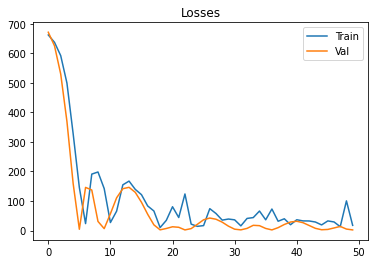

How it fits on training data:


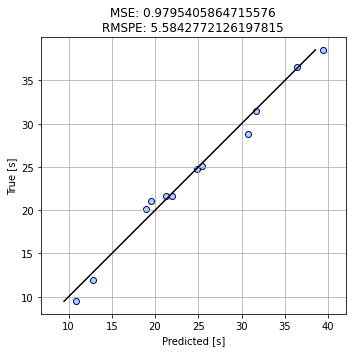

How it fits on test data:


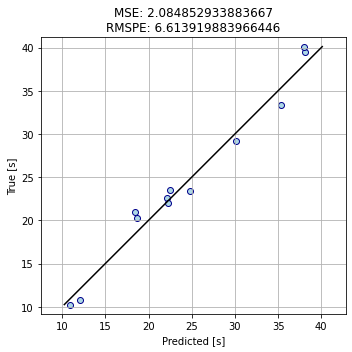

TimePredictionModel(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=33, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=32, out_features=1, bias=True)
  )
)
{'mse': [2.063698], 'rmspe': [6.728046387434006]}  <---- switching. previous best: 1000
{'mse': [5.888453], 'rmspe': [10.20088940858841]} 
{'mse': [2.0849752], 'rmspe': [8.205348998308182]} 
{'mse': [4.8408475], 'rmspe': [8.862726390361786]} 
{'mse': [3.487188], 'rmspe': [8.118622750043869]} 
{'mse': [15.8258705], 'rmspe': [16.65679663419723

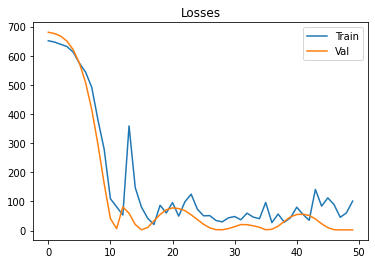

How it fits on training data:


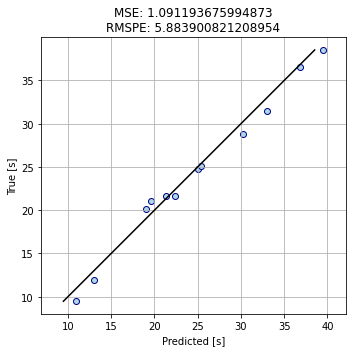

How it fits on test data:


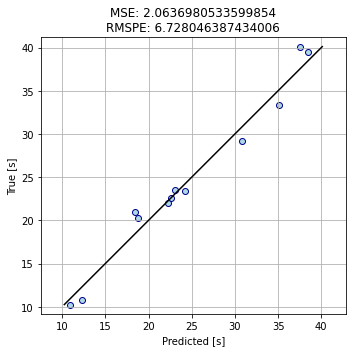

TimePredictionModel(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=33, out_features=64, bias=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=32, out_features=16, bias=True)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=16, out_features=1, bias=True)
  )
)
********** DONE!!!! ***********


In [332]:

def train_model_and_retrieve_best(n_models:int=20, metric:str='rmspe'):
    smallest_metric = 1000
    smallest_metric_model:TimePredictionFromSlicedCurves = None
    
    for i in range(n_models):
        for n_parts in [16, 32, 64]:
            for layer_sizes in [[64, 32, 16], [128, 64, 32], [32, 16, 8]]:
                for lr in [0.01, 0.001]:
                    tmp = TimePredictionFromSlicedCurves()
                    time_pred_model2, time_pred_model2_datasets = tmp.train(
                        df.query('Device == "Graphic tablet"').copy(),
                        n_parts=n_parts,
                        epochs=round(0.5 / lr),
                        lr=lr,
                        dropout=0.2,
                        layer_sizes=layer_sizes,
                        verbose=False
                    )
                    metrics = tmp.get_predicted_vs_true(x=tmp.testx, y_true=tmp.testy, plot=False)
                    # see if rmspe is any smaller than what we currently have
                    print(metrics, end=' ')

                    if metrics[metric][0] < smallest_metric:
                        print(' <---- switching. previous best:', smallest_metric, end='')
                        smallest_metric = metrics[metric][0]
                        smallest_metric_model = tmp
                    print()
        
    # check out the best model with smallest rmspe
    smallest_metric_model.plot_training_stats()
    print('How it fits on training data:')
    smallest_metric_model.get_predicted_vs_true(
        x=smallest_metric_model.trainx, y_true=smallest_metric_model.trainy, plot=True
    )
    print('How it fits on test data:')
    smallest_metric_model.get_predicted_vs_true(
        x=smallest_metric_model.testx, y_true=smallest_metric_model.testy, plot=True
    )
    print(smallest_metric_model.model)
        
    return smallest_metric_model
        
tmp2_rmspe = train_model_and_retrieve_best(n_models=1, metric='rmspe')
tmp2_mse = train_model_and_retrieve_best(n_models=1, metric='mse')
print('********** DONE!!!! ***********')


*** Alpha: 0.99 ***
Confidence interval (x0, x1): (19.09782392892774, 21.47626512136523)
The true value is: [20.231552]
Is the true value located within the confidence interval? True

*** Alpha: 0.95 ***
Confidence interval (x0, x1): (19.382159432391834, 21.191929617901135)
The true value is: [20.231552]
Is the true value located within the confidence interval? True

*** Alpha: 0.9 ***
Confidence interval (x0, x1): (19.52764101644319, 21.046448033849778)
The true value is: [20.231552]
Is the true value located within the confidence interval? True

F-test statistic and p-value (0.2793400238843623, 0.9999874507674968)
Are variances equal: True
Ttest_indResult(statistic=0.05616427614058535, pvalue=0.9553301485606376)


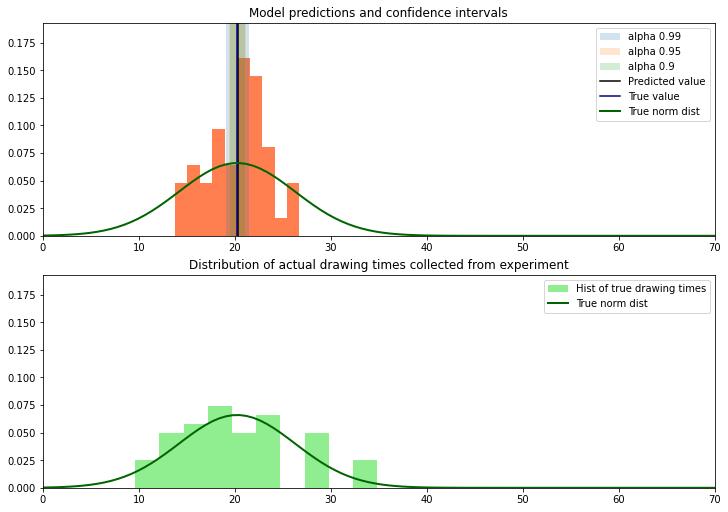


*** Alpha: 0.99 ***
Confidence interval (x0, x1): (11.228810645931109, 13.633158348209516)
The true value is: [10.819806]
Is the true value located within the confidence interval? False

*** Alpha: 0.95 ***
Confidence interval (x0, x1): (11.516243194864328, 13.345725799276297)
The true value is: [10.819806]
Is the true value located within the confidence interval? False

*** Alpha: 0.9 ***
Confidence interval (x0, x1): (11.663309396648039, 13.198659597492586)
The true value is: [10.819806]
Is the true value located within the confidence interval? False

F-test statistic and p-value (0.4958155005406527, 0.9910649325779216)
Are variances equal: True
Ttest_indResult(statistic=1.9875334856634064, pvalue=0.049773205172462254)


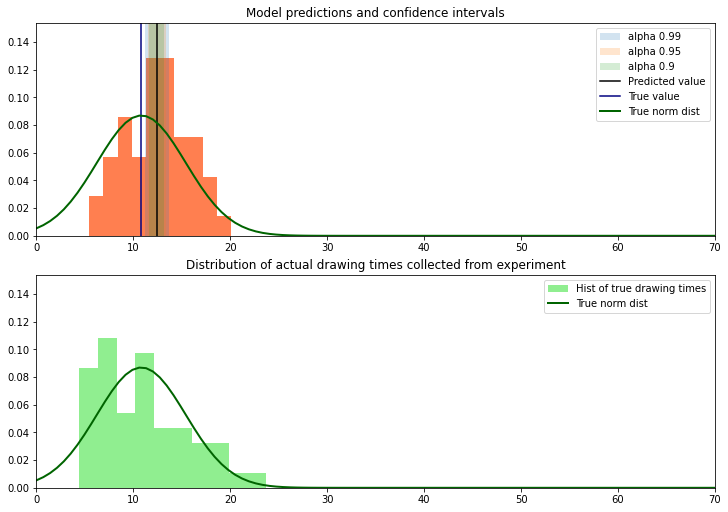


*** Alpha: 0.99 ***
Confidence interval (x0, x1): (20.31606678938783, 24.473098707438343)
The true value is: [22.58072]
Is the true value located within the confidence interval? True

*** Alpha: 0.95 ***
Confidence interval (x0, x1): (20.81302747401332, 23.97613802281285)
The true value is: [22.58072]
Is the true value located within the confidence interval? True

*** Alpha: 0.9 ***
Confidence interval (x0, x1): (21.067299721867492, 23.72186577495868)
The true value is: [22.58072]
Is the true value located within the confidence interval? True

F-test statistic and p-value (0.7540627195026051, 0.8316965884226521)
Are variances equal: True
Ttest_indResult(statistic=-0.15124503710220763, pvalue=0.880106535555414)


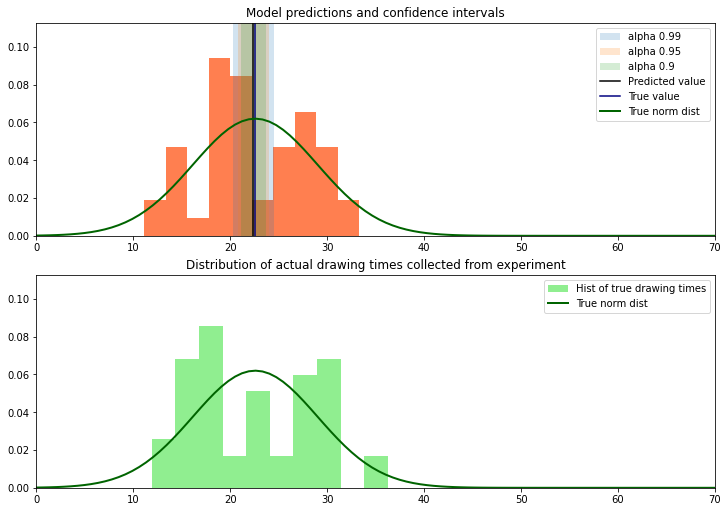


*** Alpha: 0.99 ***
Confidence interval (x0, x1): (22.58352033279374, 27.66113527633712)
The true value is: [23.475666]
Is the true value located within the confidence interval? True

*** Alpha: 0.95 ***
Confidence interval (x0, x1): (23.19053395413522, 27.05412165499564)
The true value is: [23.475666]
Is the true value located within the confidence interval? True

*** Alpha: 0.9 ***
Confidence interval (x0, x1): (23.501115299403835, 26.743540309727024)
The true value is: [23.475666]
Is the true value located within the confidence interval? False

F-test statistic and p-value (0.5785019263124174, 0.9681841434326909)
Are variances equal: True
Ttest_indResult(statistic=1.01139616691633, pvalue=0.31442319038729755)


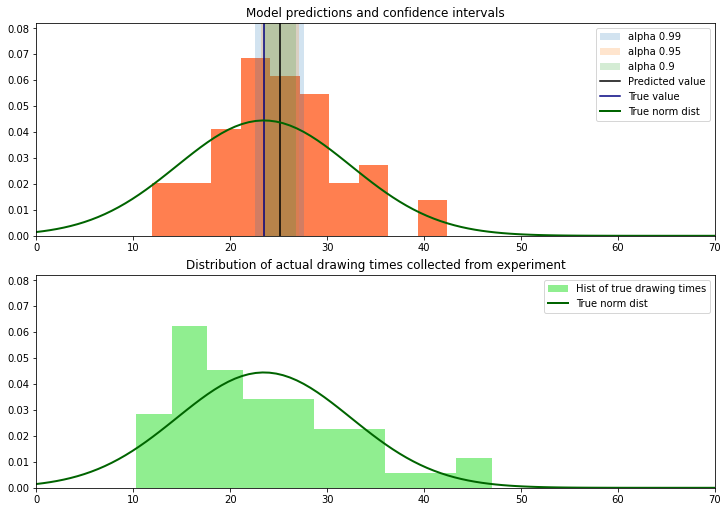


*** Alpha: 0.99 ***
Confidence interval (x0, x1): (21.65725778037028, 26.277404084864095)
The true value is: [23.420965]
Is the true value located within the confidence interval? True

*** Alpha: 0.95 ***
Confidence interval (x0, x1): (22.209582399428758, 25.725079465805617)
The true value is: [23.420965]
Is the true value located within the confidence interval? True

*** Alpha: 0.9 ***
Confidence interval (x0, x1): (22.49218186207847, 25.4424800031559)
The true value is: [23.420965]
Is the true value located within the confidence interval? True

F-test statistic and p-value (0.469317870416325, 0.9946087808295171)
Are variances equal: True
Ttest_indResult(statistic=0.3443108497092877, pvalue=0.7313816095206218)


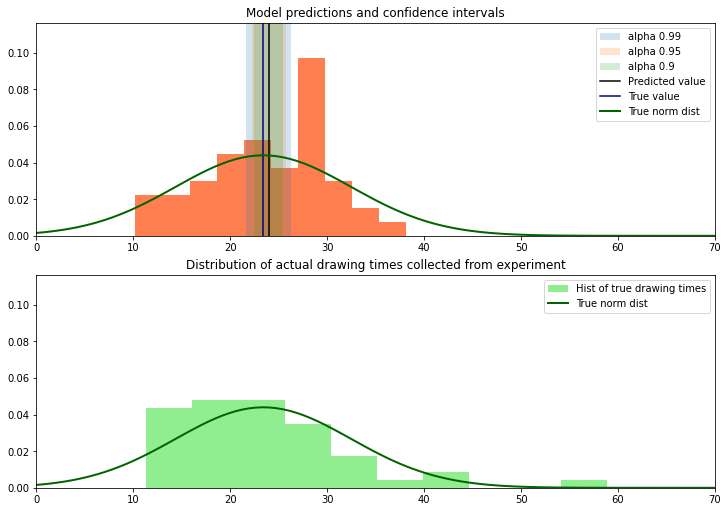


*** Alpha: 0.99 ***
Confidence interval (x0, x1): (21.200322169104226, 25.480769139489524)
The true value is: [22.062357]
Is the true value located within the confidence interval? True

*** Alpha: 0.95 ***
Confidence interval (x0, x1): (21.71203675269188, 24.96905455590187)
The true value is: [22.062357]
Is the true value located within the confidence interval? True

*** Alpha: 0.9 ***
Confidence interval (x0, x1): (21.97385790163578, 24.70723340695797)
The true value is: [22.062357]
Is the true value located within the confidence interval? True

F-test statistic and p-value (0.460313457853, 0.9955182153766503)
Are variances equal: True
Ttest_indResult(statistic=0.8636880867927343, pvalue=0.38995773444423176)


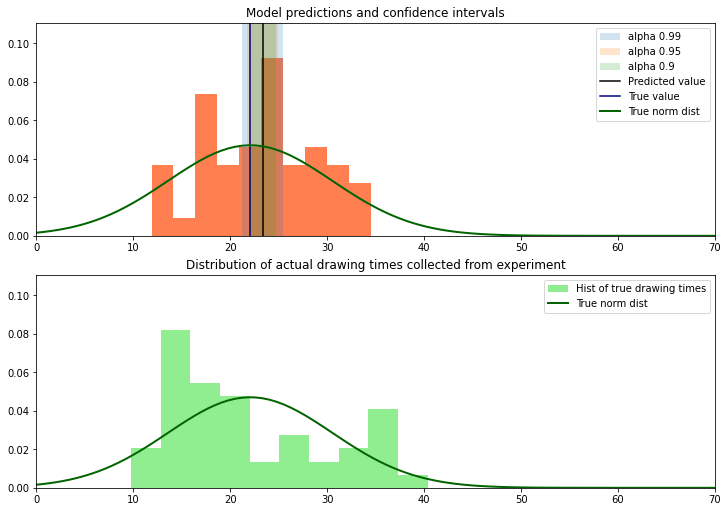


*** Alpha: 0.99 ***
Confidence interval (x0, x1): (35.674756920593765, 43.641840064269516)
The true value is: [39.508057]
Is the true value located within the confidence interval? True

*** Alpha: 0.95 ***
Confidence interval (x0, x1): (36.627197789848886, 42.689399195014396)
The true value is: [39.508057]
Is the true value located within the confidence interval? True

*** Alpha: 0.9 ***
Confidence interval (x0, x1): (37.11451859462479, 42.20207839023848)
The true value is: [39.508057]
Is the true value located within the confidence interval? True

F-test statistic and p-value (0.49138005672341384, 0.9917582410068192)
Are variances equal: True
Ttest_indResult(statistic=0.055764324857974765, pvalue=0.9556479126429274)


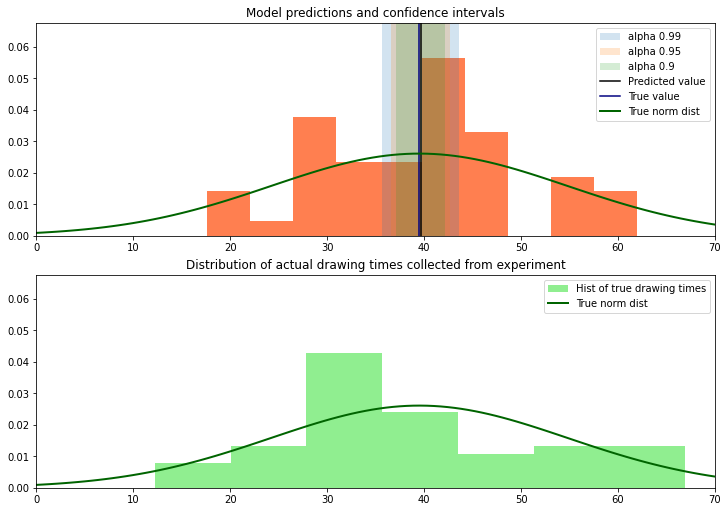


*** Alpha: 0.99 ***
Confidence interval (x0, x1): (28.49592893906422, 33.825939957420154)
The true value is: [29.211555]
Is the true value located within the confidence interval? True

*** Alpha: 0.95 ***
Confidence interval (x0, x1): (29.133115753349202, 33.18875314313517)
The true value is: [29.211555]
Is the true value located within the confidence interval? True

*** Alpha: 0.9 ***
Confidence interval (x0, x1): (29.45913535325654, 32.86273354322783)
The true value is: [29.211555]
Is the true value located within the confidence interval? False

F-test statistic and p-value (0.497787108101493, 0.9907426371248635)
Are variances equal: True
Ttest_indResult(statistic=1.0862060225790497, pvalue=0.2801654904784797)


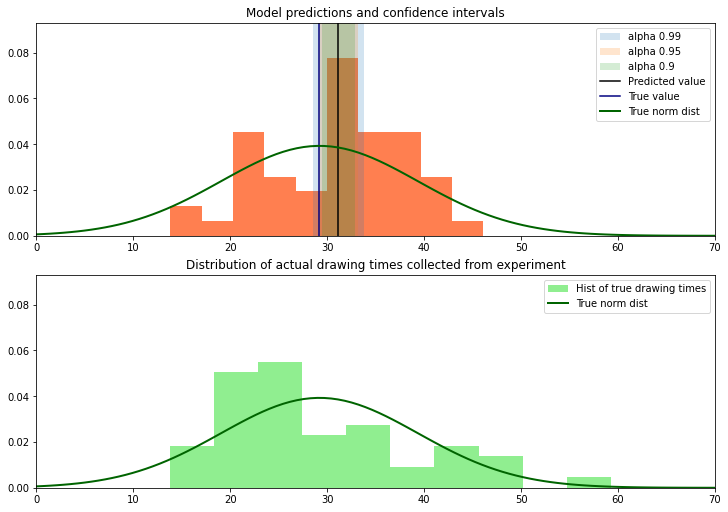


*** Alpha: 0.99 ***
Confidence interval (x0, x1): (34.02496091121042, 41.603006923262235)
The true value is: [40.107452]
Is the true value located within the confidence interval? True

*** Alpha: 0.95 ***
Confidence interval (x0, x1): (34.9308935594348, 40.697074275037856)
The true value is: [40.107452]
Is the true value located within the confidence interval? True

*** Alpha: 0.9 ***
Confidence interval (x0, x1): (35.39441821640457, 40.23354961806809)
The true value is: [40.107452]
Is the true value located within the confidence interval? True

F-test statistic and p-value (0.5171354008517908, 0.9870834250880413)
Are variances equal: True
Ttest_indResult(statistic=-0.910275554088874, pvalue=0.36500547649919557)


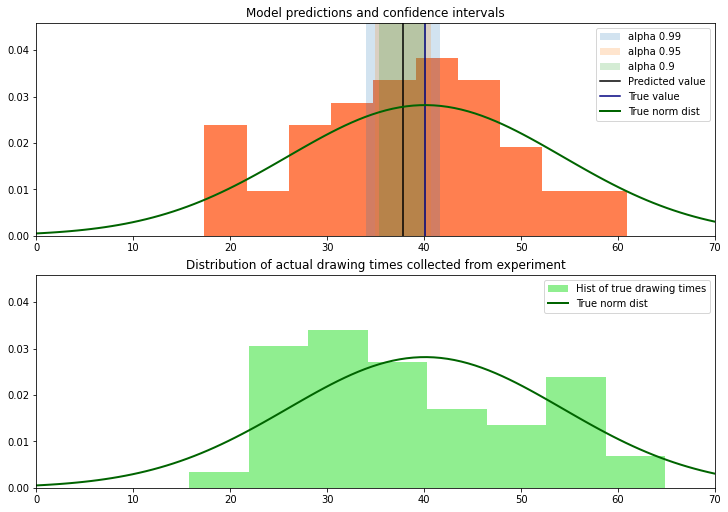


*** Alpha: 0.99 ***
Confidence interval (x0, x1): (31.43555530873881, 37.74800792368307)
The true value is: [33.386456]
Is the true value located within the confidence interval? True

*** Alpha: 0.95 ***
Confidence interval (x0, x1): (32.1901900661885, 36.993373166233376)
The true value is: [33.386456]
Is the true value located within the confidence interval? True

*** Alpha: 0.9 ***
Confidence interval (x0, x1): (32.57630245298671, 36.607260779435165)
The true value is: [33.386456]
Is the true value located within the confidence interval? True

F-test statistic and p-value (0.5685313919391494, 0.9721209919207257)
Are variances equal: True
Ttest_indResult(statistic=0.5922216867514957, pvalue=0.5551240081499158)


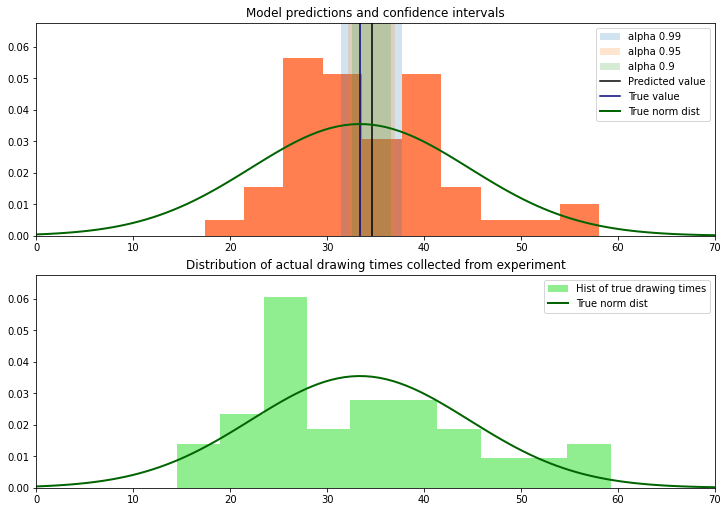


*** Alpha: 0.99 ***
Confidence interval (x0, x1): (17.713077157993247, 21.177040487270425)
The true value is: [20.912582]
Is the true value located within the confidence interval? True

*** Alpha: 0.95 ***
Confidence interval (x0, x1): (18.127183573717495, 20.762934071546177)
The true value is: [20.912582]
Is the true value located within the confidence interval? False

*** Alpha: 0.9 ***
Confidence interval (x0, x1): (18.339063049166118, 20.551054596097554)
The true value is: [20.912582]
Is the true value located within the confidence interval? False

F-test statistic and p-value (0.28592073873060986, 0.9999827388097227)
Are variances equal: True
Ttest_indResult(statistic=-1.0291405531597182, pvalue=0.30605448170047084)


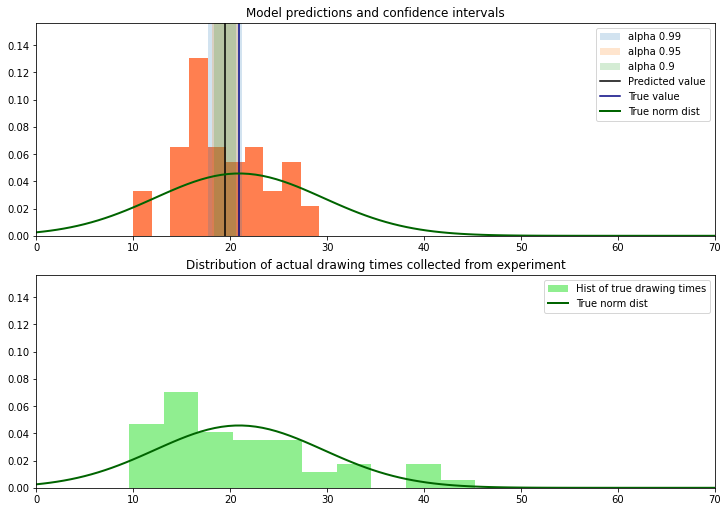


*** Alpha: 0.99 ***
Confidence interval (x0, x1): (9.208850762140594, 11.442823508489289)
The true value is: [10.254483]
Is the true value located within the confidence interval? True

*** Alpha: 0.95 ***
Confidence interval (x0, x1): (9.47591549663048, 11.175758773999403)
The true value is: [10.254483]
Is the true value located within the confidence interval? True

*** Alpha: 0.9 ***
Confidence interval (x0, x1): (9.61256041133333, 11.039113859296553)
The true value is: [10.254483]
Is the true value located within the confidence interval? True

F-test statistic and p-value (0.3466213201413923, 0.9997949391295367)
Are variances equal: True
Ttest_indResult(statistic=0.08348230134866441, pvalue=0.9336455754405266)


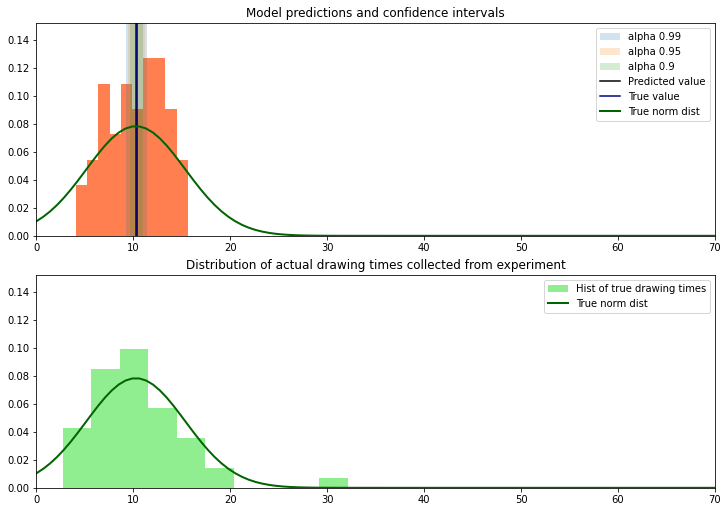

Times the accurate value was in conf interval:[11. 10.  8.] / 12
This is with monte carlo simulation:


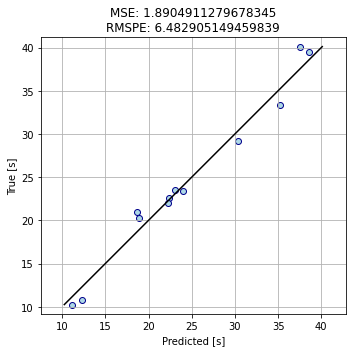

This is without Monte Carlo:


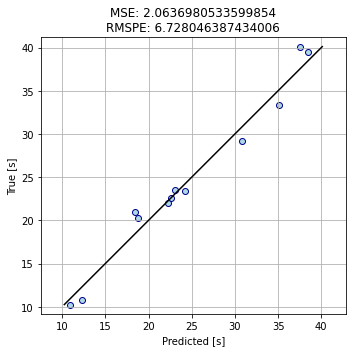

{'mse': [2.063698], 'rmspe': [6.728046387434006]}

In [335]:
# pick which model to use: the one with smallest MSE or smallest RMSPE
tmp2 = tmp2_rmspe
tmp2 = tmp2_mse
def plot_predictions_and_real_time_dist():
    """ plot the distributions of:
        - time predictions
        - actual times
    """
    conf_interval_alphas = [0.99, 0.95, 0.90]
    nr_times_in_conf_interval = np.zeros(len(conf_interval_alphas))
    for idx in range(tmp2.testy.shape[0]):
        # plot the dist of the original drawings
        # first, get the ids of which figure and which projection this is
        figureid = tmp2.test_df.iloc[idx]['FigureID']
        projectionid = tmp2.test_df.iloc[idx]['Projection']
        deviceid = tmp2.test_df.iloc[idx]['Device']
        device = "Mouse" if deviceid == 0 else "Graphic tablet"
        all_drawings_for_this_func = df.query(
            f'Device == "{device}" and ' +
            f'Projection == {projectionid} and ' +
            f'FigureID == {figureid}'
        ).copy()
        fig, axes = plt.subplots(2, 1, figsize=(10, 7), constrained_layout=True)
        _, predictions, is_in_conf_interval = plot_prediction_dist(
            tmp2, n_samples=len(all_drawings_for_this_func),
            sample_idx=idx, conf_interval_alphas=conf_interval_alphas,
            n_bins=10,
            ax=axes[0]
        )
        nr_times_in_conf_interval += is_in_conf_interval
        # plot the norm dist on the figure with real drawing times
        avg_draw_time = all_drawings_for_this_func['Drawing time'].mean()
        var_draw_time = all_drawings_for_this_func['Drawing time'].var()
        std_draw_time = np.sqrt(var_draw_time)
        
        axes[1].hist(
            all_drawings_for_this_func['Drawing time'],
            density=True, bins=10, label='Hist of true drawing times',
            color='lightgreen'
        )
        axes[1].set_xlim(axes[0].get_xlim())
        axes[1].set_ylim(axes[0].get_ylim())
        norm_x = np.linspace(*axes[0].get_xlim(), 100)
        norm_y = 1/(std_draw_time * np.sqrt(2 * np.pi)) * np.exp(-(norm_x - avg_draw_time)**2 / (2*std_draw_time**2) )
        axes[1].plot(norm_x, norm_y, linewidth=2, color='darkgreen', label='True norm dist')
        axes[0].plot(norm_x, norm_y, linewidth=2, color='darkgreen', label='True norm dist')
        axes[0].set_title('Model predictions and confidence intervals')
        axes[1].set_title('Distribution of actual drawing times collected from experiment')
        
        import scipy.stats
        print()
        # perform F test to see if variances are equal
        predictions = np.ravel(predictions)
        drawing_times = list(all_drawings_for_this_func['Drawing time'])
        # ddof=1 means we calculate the sample variance.
        # by default, ddof is 0 which means we calculate the population variance
        f = np.var(predictions, ddof=1) /  np.var(drawing_times, ddof=1)
        dfn = len(predictions) - 1
        dfd = len(predictions) - 1
        f_test_p = 1 - scipy.stats.f.cdf(f, dfn, dfd)
        print('F-test statistic and p-value', (f, f_test_p))
        print('Are variances equal:', f_test_p > 0.05)
        ttest = scipy.stats.ttest_ind(predictions, drawing_times, equal_var=f_test_p>0.05)
        print(ttest)
        
        for a in axes.flat:
            a.legend()
        
        plt.show()
    print(f'Times the accurate value was in conf interval:{nr_times_in_conf_interval} / {tmp2.testy.shape[0]}')

def get_predictions_for_dataset_from_distribution(
    model_wrapper:TimePredictionFromSlicedCurves,
    n_samples:int=100
):
    all_predictions = []
    for idx in range(model_wrapper.testy.shape[0]):
        predictions_for_this_entry = make_prediction_distribution(
            model_wrapper, n_samples=n_samples, sample_idx=idx
        )
        prediction = np.mean(predictions_for_this_entry)
        all_predictions.append([prediction])
    return np.array(all_predictions)

plot_predictions_and_real_time_dist()

# plot the predicted values sampled from prediction dist and plot it against real y values
print('This is with monte carlo simulation:')
tmp2.get_predicted_vs_true(
    x=tmp2.testx,
    y_true=tmp2.testy,
    y_pred=get_predictions_for_dataset_from_distribution(tmp2, n_samples=500),
    plot=True
)
print('This is without Monte Carlo:')
tmp2.get_predicted_vs_true(
    x=tmp2.testx,
    y_true=tmp2.testy,
    plot=True
)

# Figuring out which parts of a function were the hard and which were easy
## Entropy approach